In [1]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# visualization
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:

IMAGE_ROOT = "./data/train/DCM"
LABEL_ROOT = "./data/train/outputs_json"
META_ROOT = "./data/meta_data.xlsx"

In [8]:
# 데이터 경로를 입력하세요

CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

#
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

print(len(pngs))
print(len(jsons))

jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}
pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in pngs}


475
800


In [10]:
# assert len(jsons_fn_prefix - pngs_fn_prefix) == 0
# assert len(pngs_fn_prefix - jsons_fn_prefix) == 0

pngs = sorted(pngs)
jsons = sorted(jsons)

In [11]:
class XRayDataset(Dataset):
    def __init__(self, is_train=True, transforms=None):
        _filenames = np.array(pngs)
        _labelnames = np.array(jsons)
        
        # split train-valid
        # 한 폴더 안에 한 인물의 양손에 대한 `.dcm` 파일이 존재하기 때문에
        # 폴더 이름을 그룹으로 해서 GroupKFold를 수행합니다.
        # 동일 인물의 손이 train, valid에 따로 들어가는 것을 방지합니다.
        groups = [os.path.dirname(fname) for fname in _filenames]
        
        # dummy label
        ys = [0 for fname in _filenames]
        
        # 전체 데이터의 20%를 validation data로 쓰기 위해 `n_splits`를
        # 5으로 설정하여 KFold를 수행합니다.
        gkf = GroupKFold(n_splits=5)
        
        filenames = []
        labelnames = []
        for i, (x, y) in enumerate(gkf.split(_filenames, ys, groups)):
            if is_train:
                # 0번을 validation dataset으로 사용합니다.
                if i == 0:
                    continue
                    
                filenames += list(_filenames[y])
                labelnames += list(_labelnames[y])
            
            else:
                filenames = list(_filenames[y])
                labelnames = list(_labelnames[y])
                
                # skip i > 0
                break
        
        self.filenames = filenames
        self.labelnames = labelnames
        self.is_train = is_train
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        label_name = self.labelnames[item]
        label_path = os.path.join(LABEL_ROOT, label_name)
        
        # (H, W, NC) 모양의 label을 생성합니다.
        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)
        
        # label 파일을 읽습니다.
        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]
        
        # 클래스 별로 처리합니다.
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])
            
            # polygon 포맷을 dense한 mask 포맷으로 바꿉니다.
            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label
        
        if self.transforms is not None:
            inputs = {"image": image, "mask": label} if self.is_train else {"image": image}
            result = self.transforms(**inputs)
            
            image = result["image"]
            label = result["mask"] if self.is_train else label

        # to tenser will be done later
        image = image.transpose(2, 0, 1)    # channel first 포맷으로 변경합니다.
        label = label.transpose(2, 0, 1)
        
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()
            
        return image, label

In [12]:
# 시각화를 위한 팔레트를 설정합니다.
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# 시각화 함수입니다. 클래스가 2개 이상인 픽셀을 고려하지는 않습니다.
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

tf = A.Resize(512, 512)

train_dataset = XRayDataset(is_train=True, transforms=tf)
valid_dataset = XRayDataset(is_train=False, transforms=tf)
image, label = train_dataset[0]

print(image.shape, label.shape)

print(len(train_dataset))

torch.Size([3, 512, 512]) torch.Size([29, 512, 512])
379


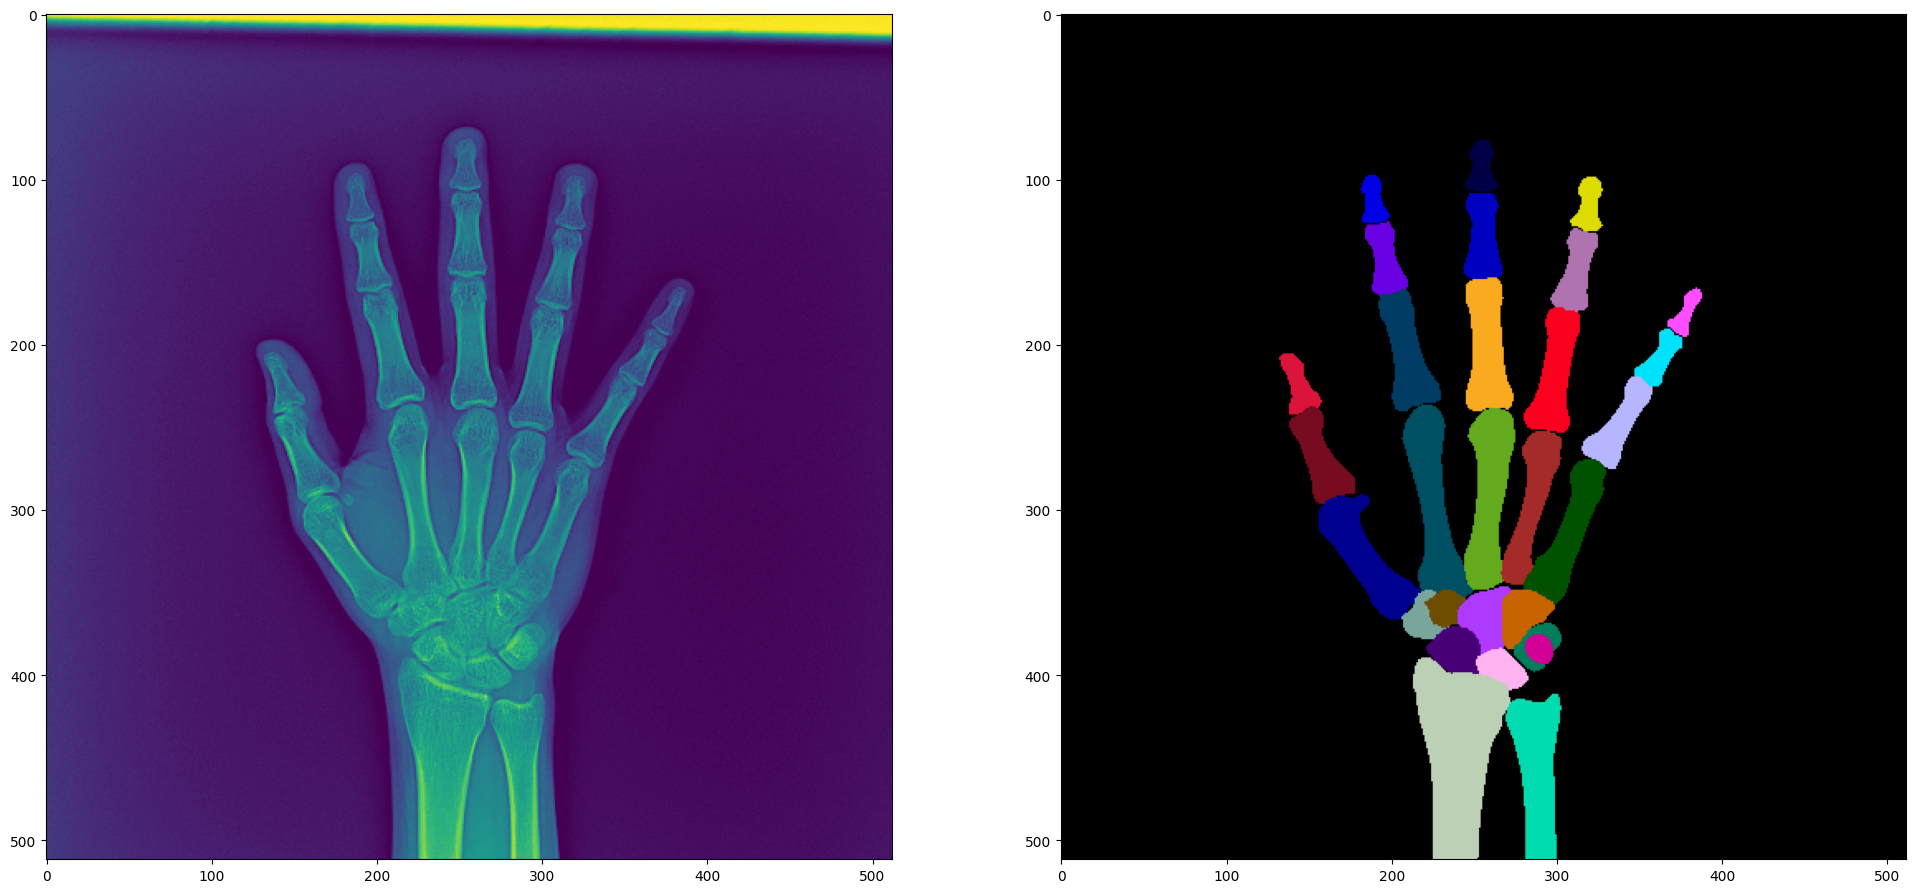

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image[0])    # color map 적용을 위해 channel 차원을 생략합니다.
ax[1].imshow(label2rgb(label))

plt.show()

# EDA
1. 각 이미지 내에서 multi label을 가진 값 pixel count(면적) 비교 
2. 한 이미지 내에서 29개 label 이 모두 등장하는지 여부 

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 읽기
df = pd.read_csv('./train_annotation.csv')

# 'points'의 리스트 내 각 [x, y] 좌표를 튜플로 변환하고, 전체 리스트를 다시 튜플로 변환하여 해시 가능하게 만듭니다.
# eval 대신 ast.literal_eval을 사용하여 안전하게 변환
import ast
df['points'] = df['points'].apply(lambda x: tuple(tuple(coord) for coord in ast.literal_eval(x)))

# 'img_name'과 'points'로 그룹화하고, 각 그룹의 'label'의 고유 개수를 계산합니다.
grouped = df.groupby(['img_name', 'points']).agg({'label': 'nunique'}).reset_index()

# 'label'의 개수가 2 이상인 경우만 필터링
multi_label_pixels = grouped[grouped['label'] > 1]

# 이미지별 multi label pixel count 계산
multi_label_count = multi_label_pixels['img_name'].value_counts()

# 데이터가 있는 경우에만 막대 차트 그리기
if not multi_label_count.empty:
    plt.figure(figsize=(12, 6))
    multi_label_count.plot(kind='bar')
    plt.title('Multi Label Pixel Count per Image')
    plt.xlabel('Image Name')
    plt.ylabel('Count of Multi Label Pixels')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No images with multi-label pixels found.")

No images with multi-label pixels found.


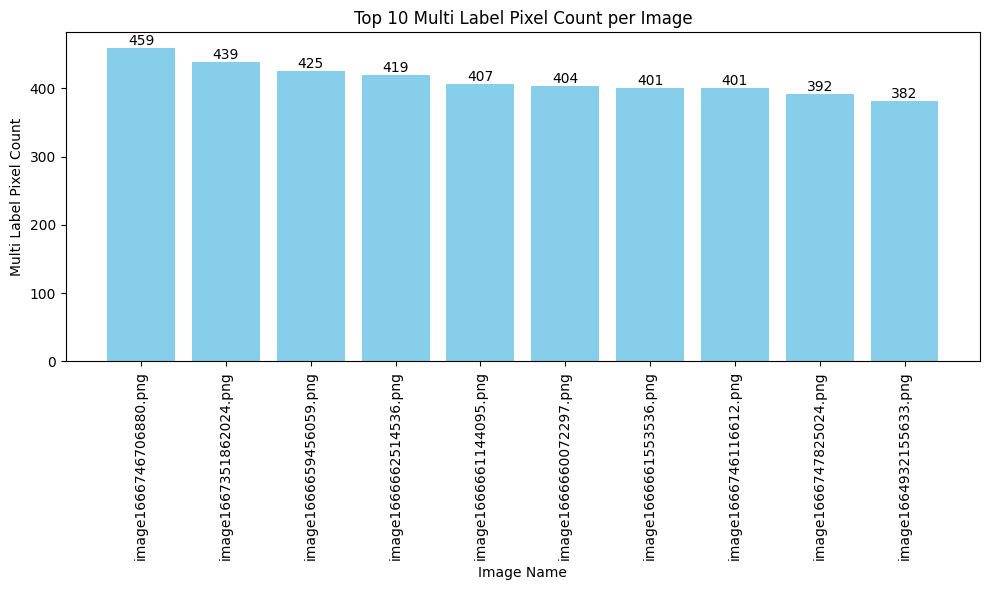

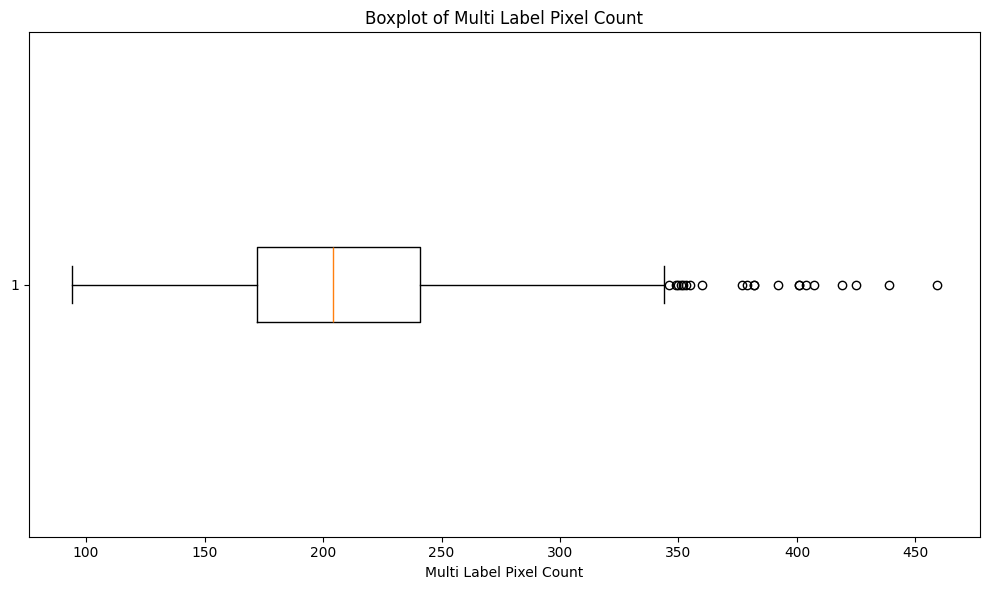

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
from collections import Counter

# 데이터 불러오기
df = pd.read_csv("./train_annotation.csv")

# "points"를 리스트 형식으로 변환
df['points'] = df['points'].apply(literal_eval)

# img_name별 multi label pixel count 계산
multi_label_counts = []

for img_name, group in df.groupby('img_name'):
    point_to_labels = Counter()
    
    for _, row in group.iterrows():
        points = [tuple(point) for point in row['points']]
        label = row['label']
        for point in points:
            point_to_labels[point] += 1

    multi_label_count = sum(count > 1 for count in point_to_labels.values())
    multi_label_counts.append((img_name, multi_label_count))

# DataFrame 생성
multi_label_df = pd.DataFrame(multi_label_counts, columns=['img_name', 'multi_label_count'])

# (1) 상위 10개 이미지에 대한 막대 그래프 그리기
top_10_images = multi_label_df.nlargest(10, 'multi_label_count')

plt.figure(figsize=(10, 6))
bars = plt.bar(top_10_images['img_name'], top_10_images['multi_label_count'], color='skyblue')
plt.xlabel('Image Name')
plt.ylabel('Multi Label Pixel Count')
plt.title('Top 10 Multi Label Pixel Count per Image')
plt.xticks(rotation=90)

# 수치 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# (2) multi_label_df에 대한 사분위수 그래프 그리기
plt.figure(figsize=(10, 6))
plt.boxplot(multi_label_df['multi_label_count'], vert=False)
plt.xlabel('Multi Label Pixel Count')
plt.title('Boxplot of Multi Label Pixel Count')
plt.tight_layout()
plt.show()

# 
1. 손(전체), 손가락("finger-1 ~ finger-19), 손등(그외 8개), 팔("ulna, Ridus) 3부위 masking point를 train_annotation.csv에 추가 
2. (1) 팔의 

1. labe 별 점 분포
2. R,L 별 점 분포

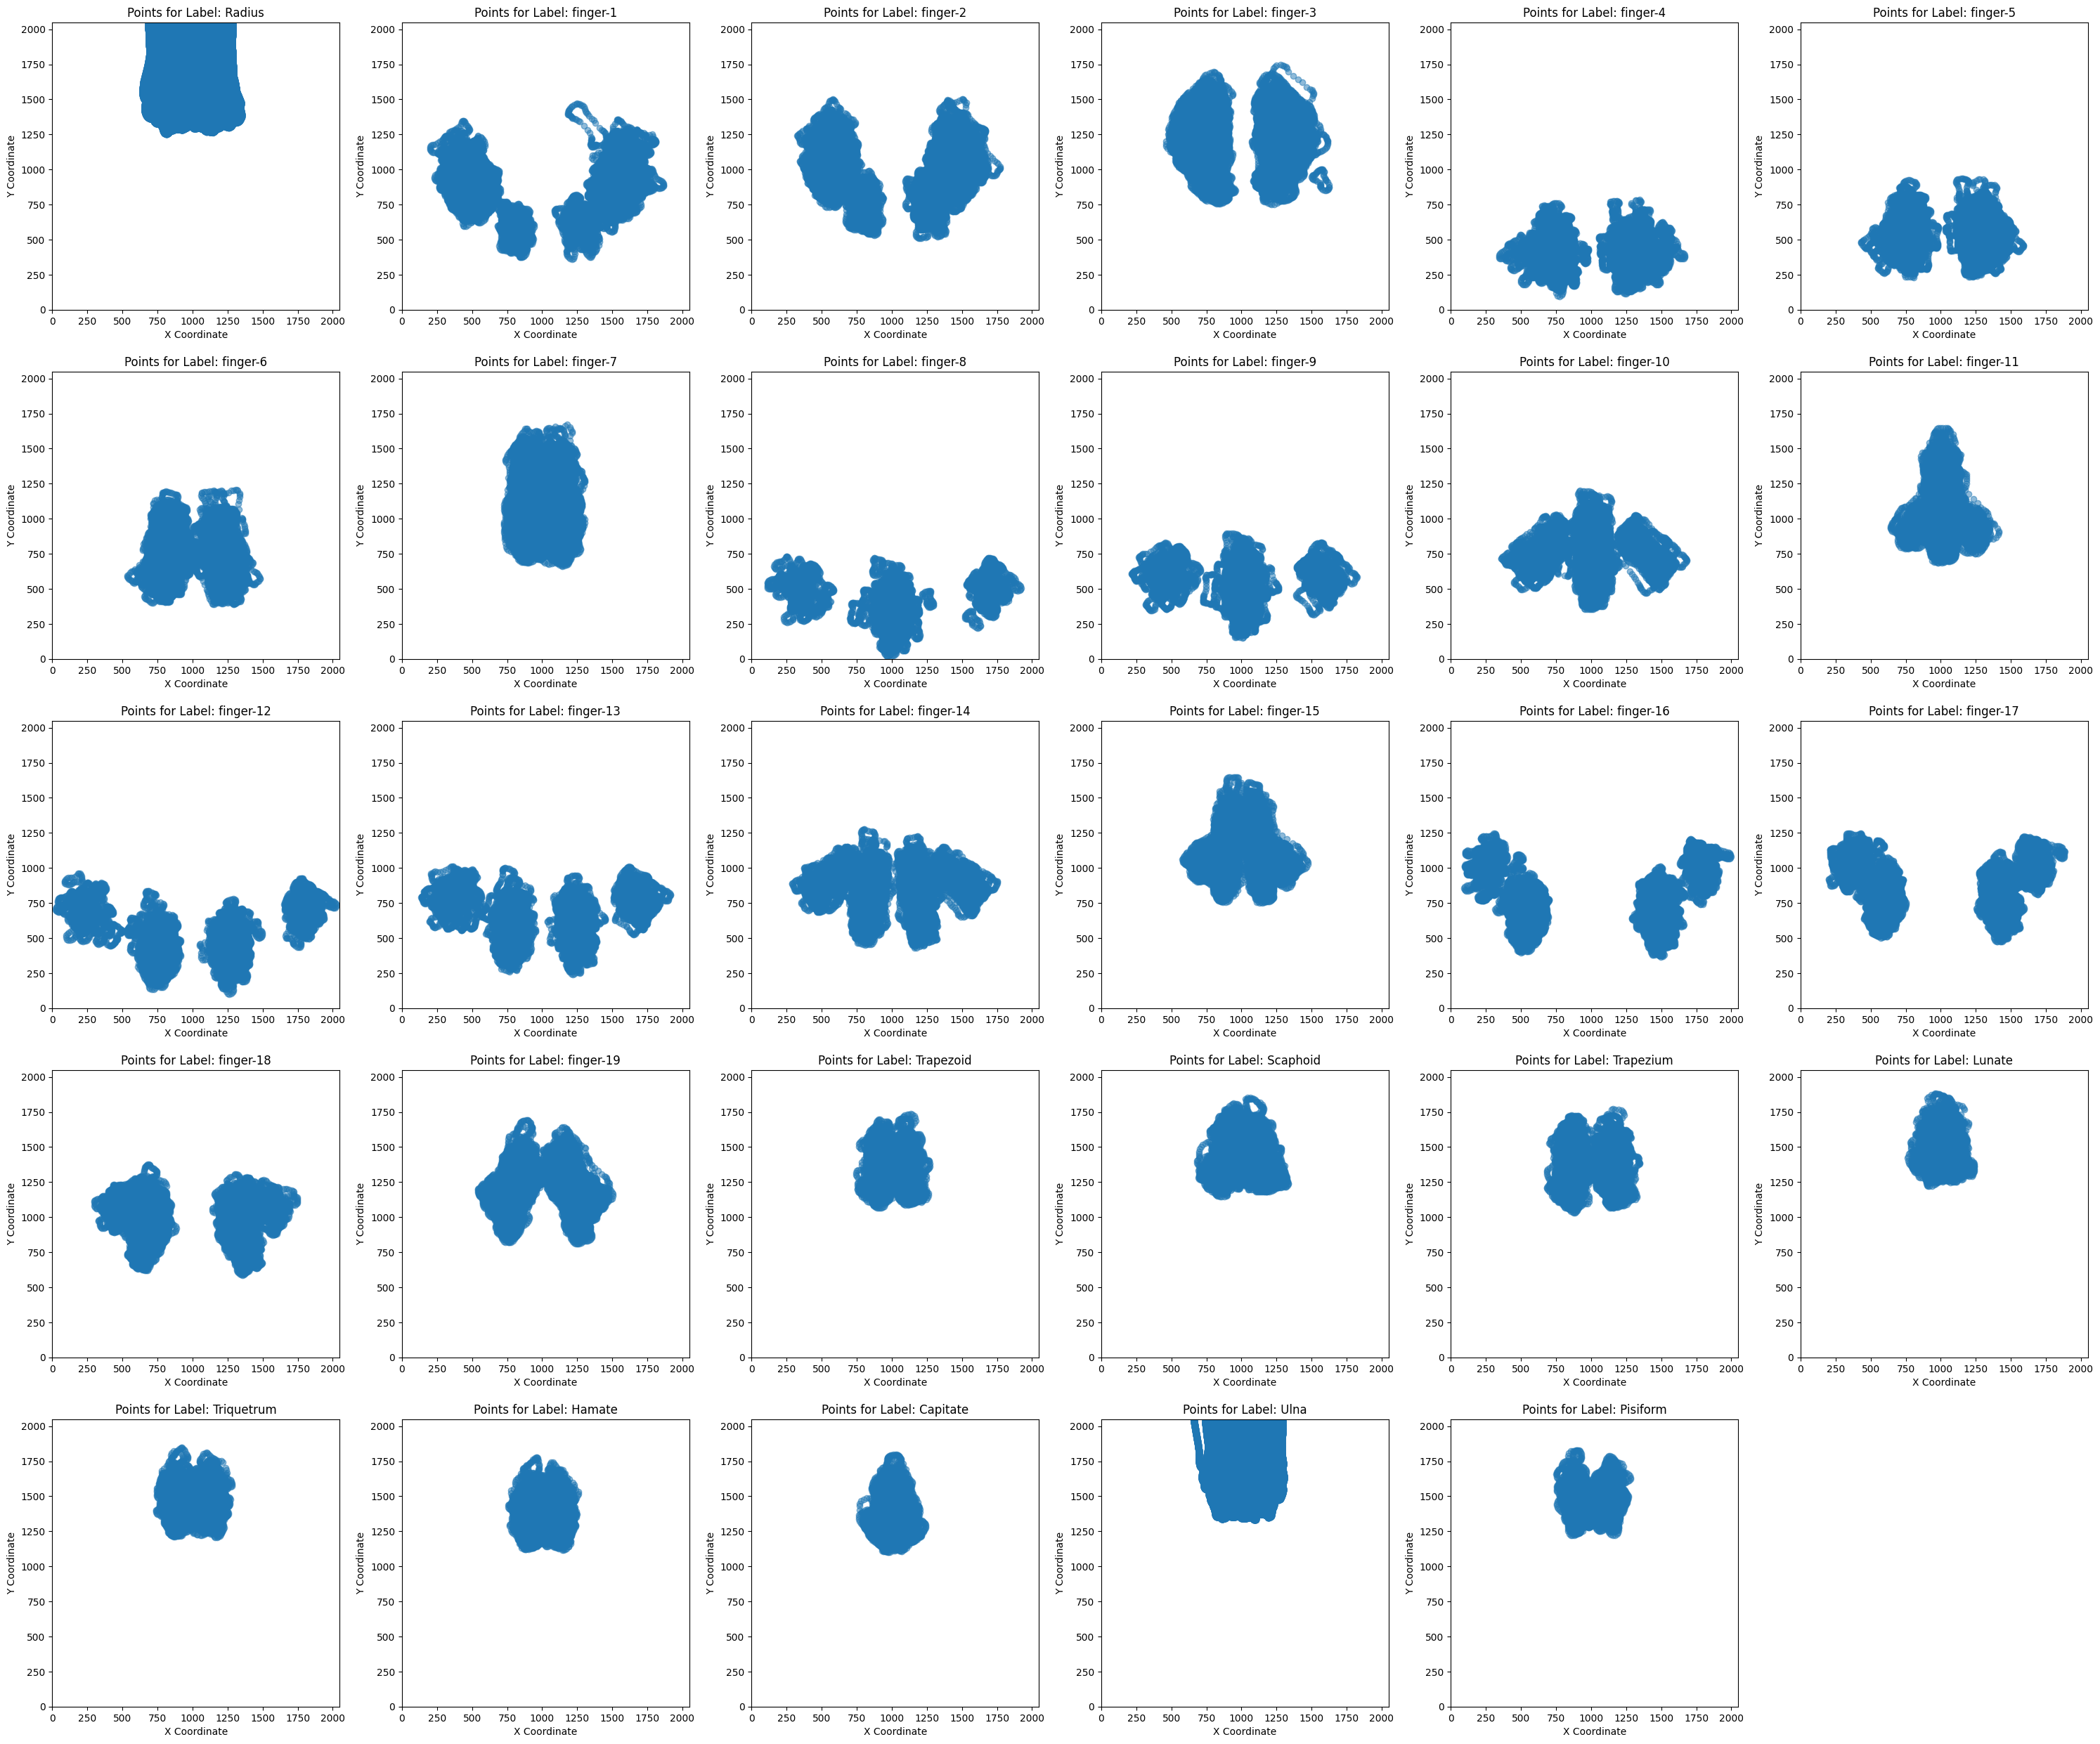

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
from collections import defaultdict

# 데이터 불러오기
df = pd.read_csv("./train_annotation.csv")

# "points"를 리스트 형식으로 변환
df['points'] = df['points'].apply(literal_eval)

# 이미지 크기 설정
image_size = (2048, 2048)

# 레이블별로 포인트 저장
label_points = defaultdict(list)

# 각 레이블별로 포인트 수집
for _, row in df.iterrows():
    points = row['points']
    label = row['label']
    for point in points:
        label_points[label].append(point)

# 서브플롯 설정
num_labels = len(label_points)
cols = 6
rows = (num_labels // cols) + (num_labels % cols > 0)  # 필요한 행 수 계산

fig, axes = plt.subplots(rows, cols, figsize=(30, 5 * rows))
axes = axes.flatten()  # 2D 배열을 1D로 변환

# 각 레이블별로 점 찍기
for ax, (label, points) in zip(axes, label_points.items()):
    ax.set_xlim(0, image_size[0])
    ax.set_ylim(0, image_size[1])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f'Points for Label: {label}')
    
    # x, y 좌표 분리
    x_coords, y_coords = zip(*points)  # x, y 좌표 분리
    ax.scatter(x_coords, y_coords, alpha=0.5)  # 점 찍기

    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

# 남은 서브플롯 비우기
for i in range(num_labels, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

/tmp/ipykernel_747659/2172705567.py:69: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # 전체 제목을 위한 여백 조정


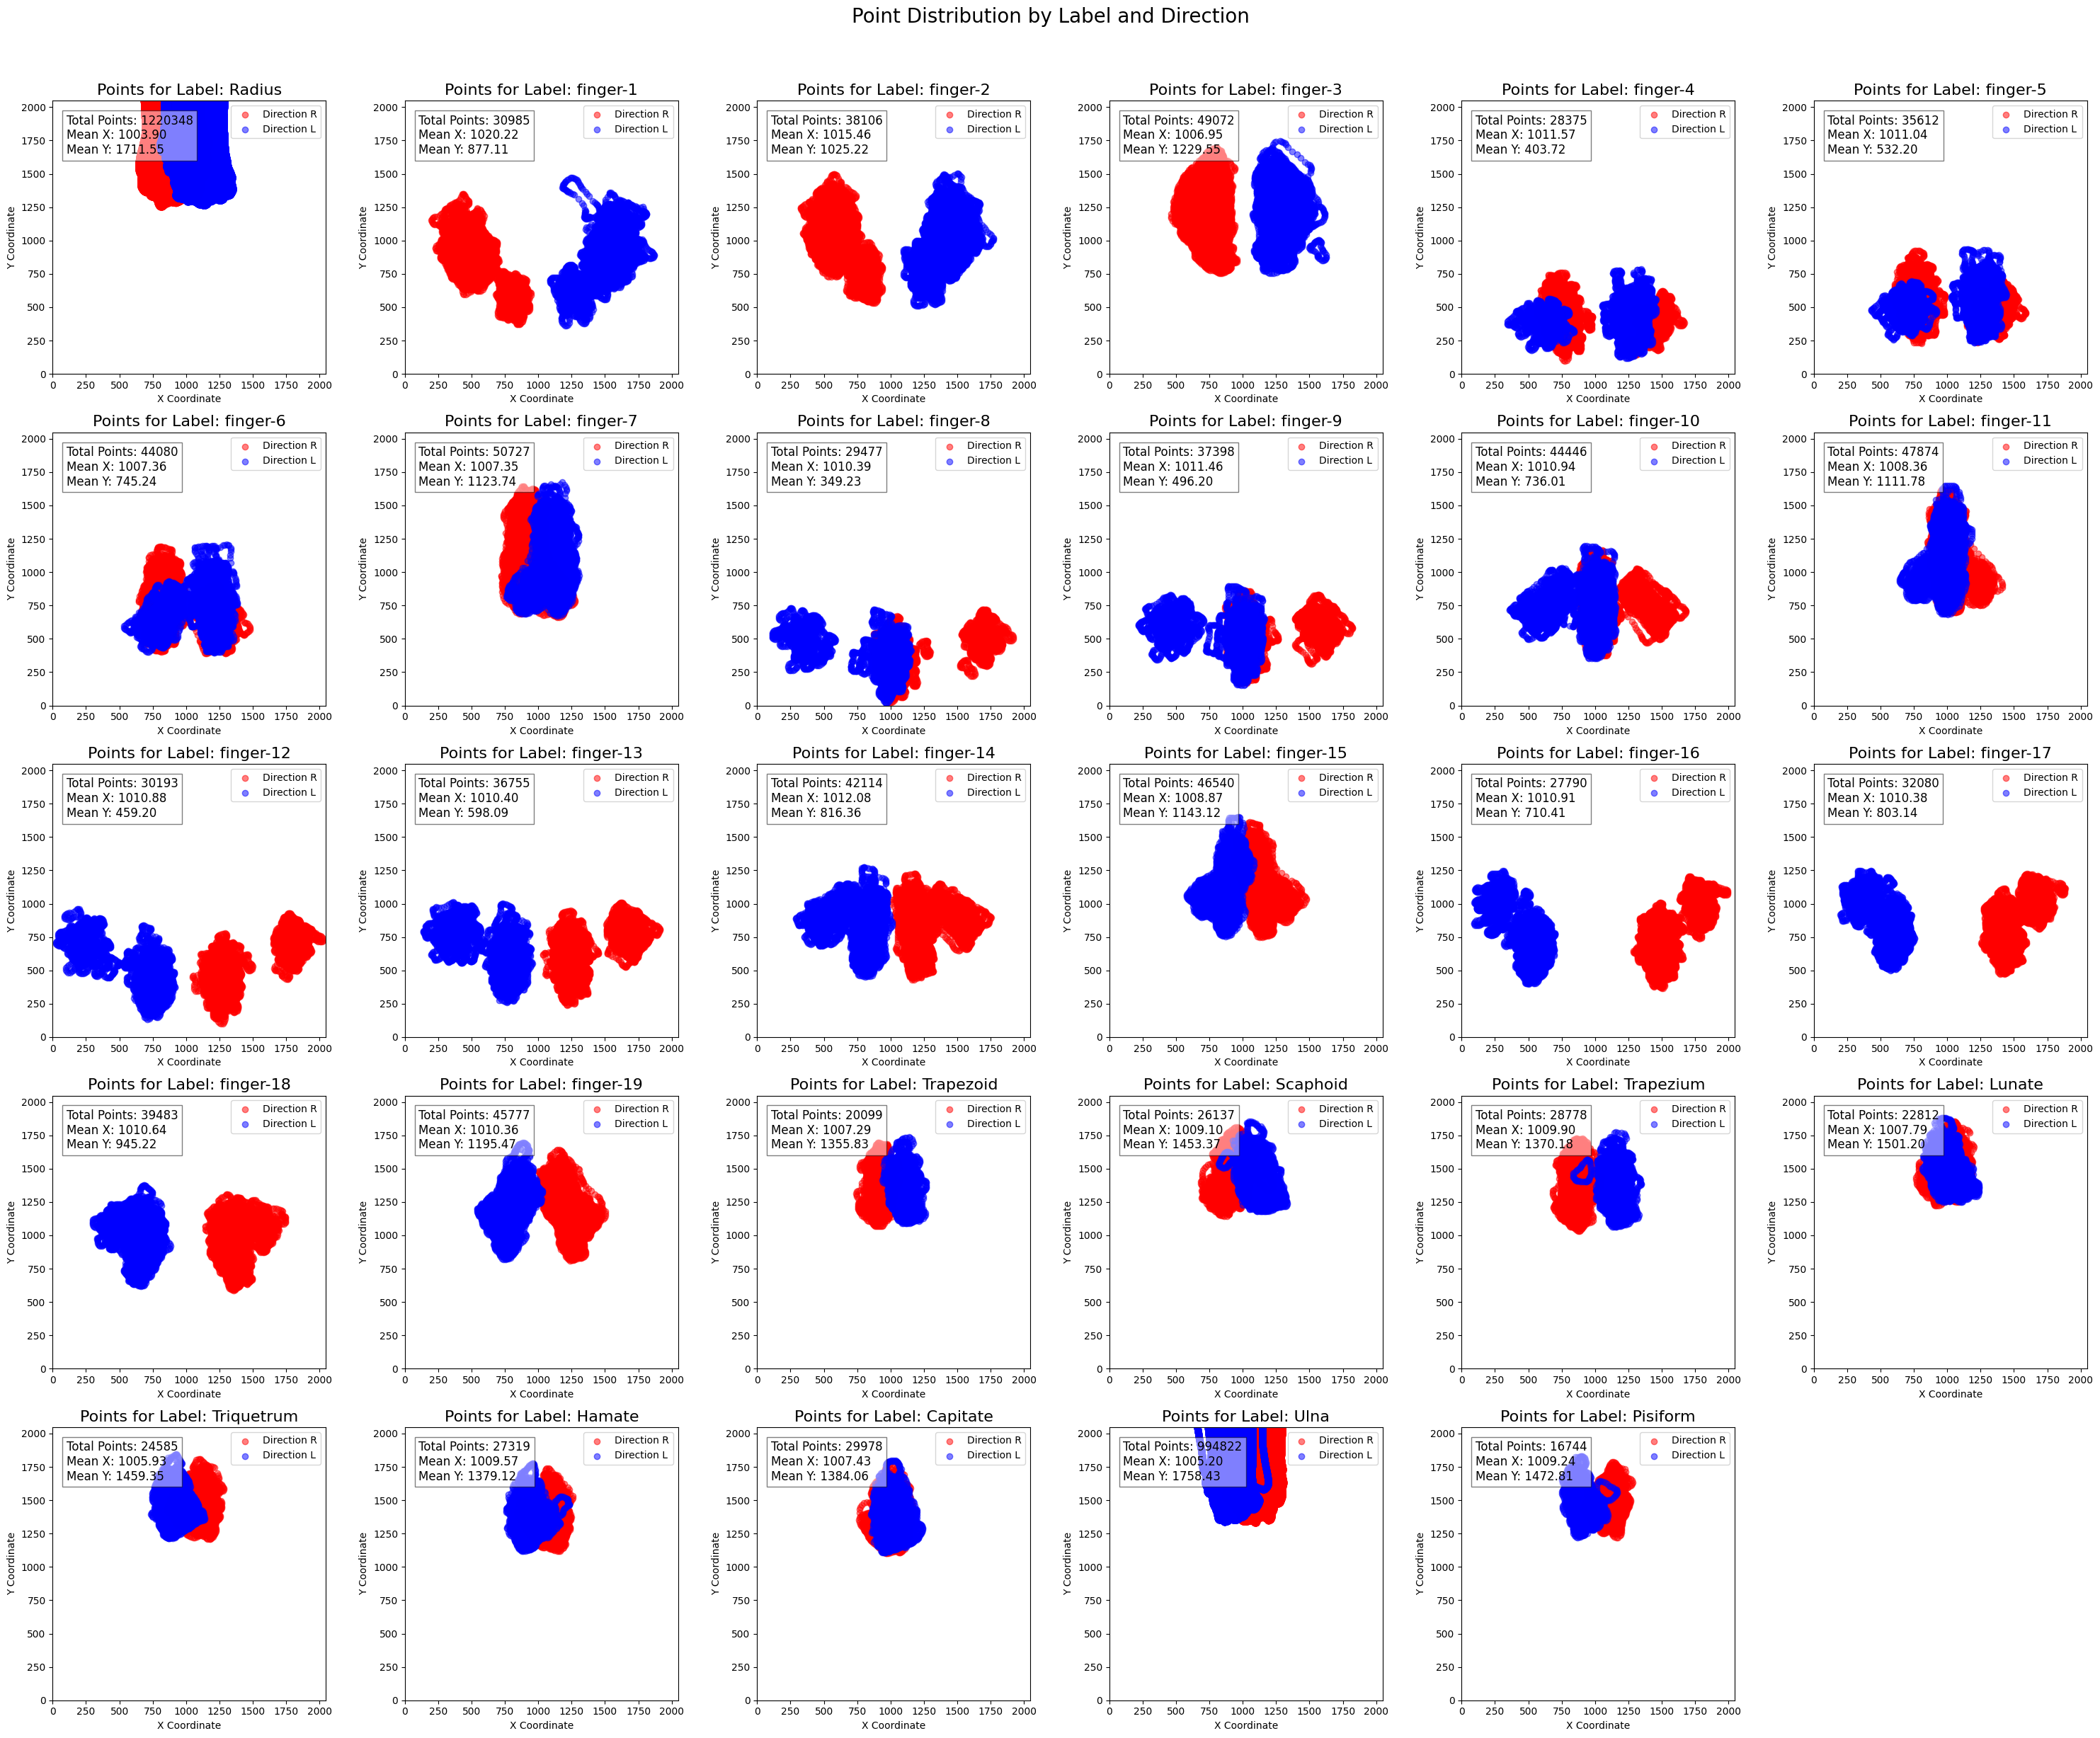

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
from collections import defaultdict

# 데이터 불러오기
df = pd.read_csv("./train_annotation.csv")

# "points"를 리스트 형식으로 변환
df['points'] = df['points'].apply(literal_eval)

# 이미지 크기 설정
image_size = (2048, 2048)

# 레이블별로 포인트 저장
label_points = defaultdict(lambda: {'R': [], 'L': []})

# 각 레이블별로 포인트 수집
for _, row in df.iterrows():
    points = row['points']
    label = row['label']
    direction = row['direction']
    for point in points:
        label_points[label][direction].append(point)

# 서브플롯 설정
num_labels = len(label_points)
cols = 6
rows = (num_labels // cols) + (num_labels % cols > 0)  # 필요한 행 수 계산

fig, axes = plt.subplots(rows, cols, figsize=(30, 5 * rows))
axes = axes.flatten()  # 2D 배열을 1D로 변환

# 각 레이블별로 점 찍기 및 통계치 출력
for ax, (label, directions) in zip(axes, label_points.items()):
    ax.set_xlim(0, image_size[0])
    ax.set_ylim(0, image_size[1])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f'Points for Label: {label}', fontsize=16)  # 서브플롯 제목 추가
    
    # R 방향 포인트
    if directions['R']:
        x_coords_r, y_coords_r = zip(*directions['R'])  # x, y 좌표 분리
        ax.scatter(x_coords_r, y_coords_r, color='red', alpha=0.5, label='Direction R')  # 빨간색 점 찍기

    # L 방향 포인트
    if directions['L']:
        x_coords_l, y_coords_l = zip(*directions['L'])  # x, y 좌표 분리
        ax.scatter(x_coords_l, y_coords_l, color='blue', alpha=0.5, label='Direction L')  # 파란색 점 찍기

    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.legend()

    # 통계치 출력
    total_points = len(directions['R']) + len(directions['L'])
    mean_x = (sum(x_coords_r) + sum(x_coords_l)) / total_points if total_points > 0 else 0
    mean_y = (sum(y_coords_r) + sum(y_coords_l)) / total_points if total_points > 0 else 0
    ax.text(0.05, 0.95, f'Total Points: {total_points}\nMean X: {mean_x:.2f}\nMean Y: {mean_y:.2f}', 
            transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

# 전체 제목 추가
fig.suptitle('Point Distribution by Label and Direction', fontsize=20)

# 남은 서브플롯 비우기
for i in range(num_labels, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # 전체 제목을 위한 여백 조정
plt.show()

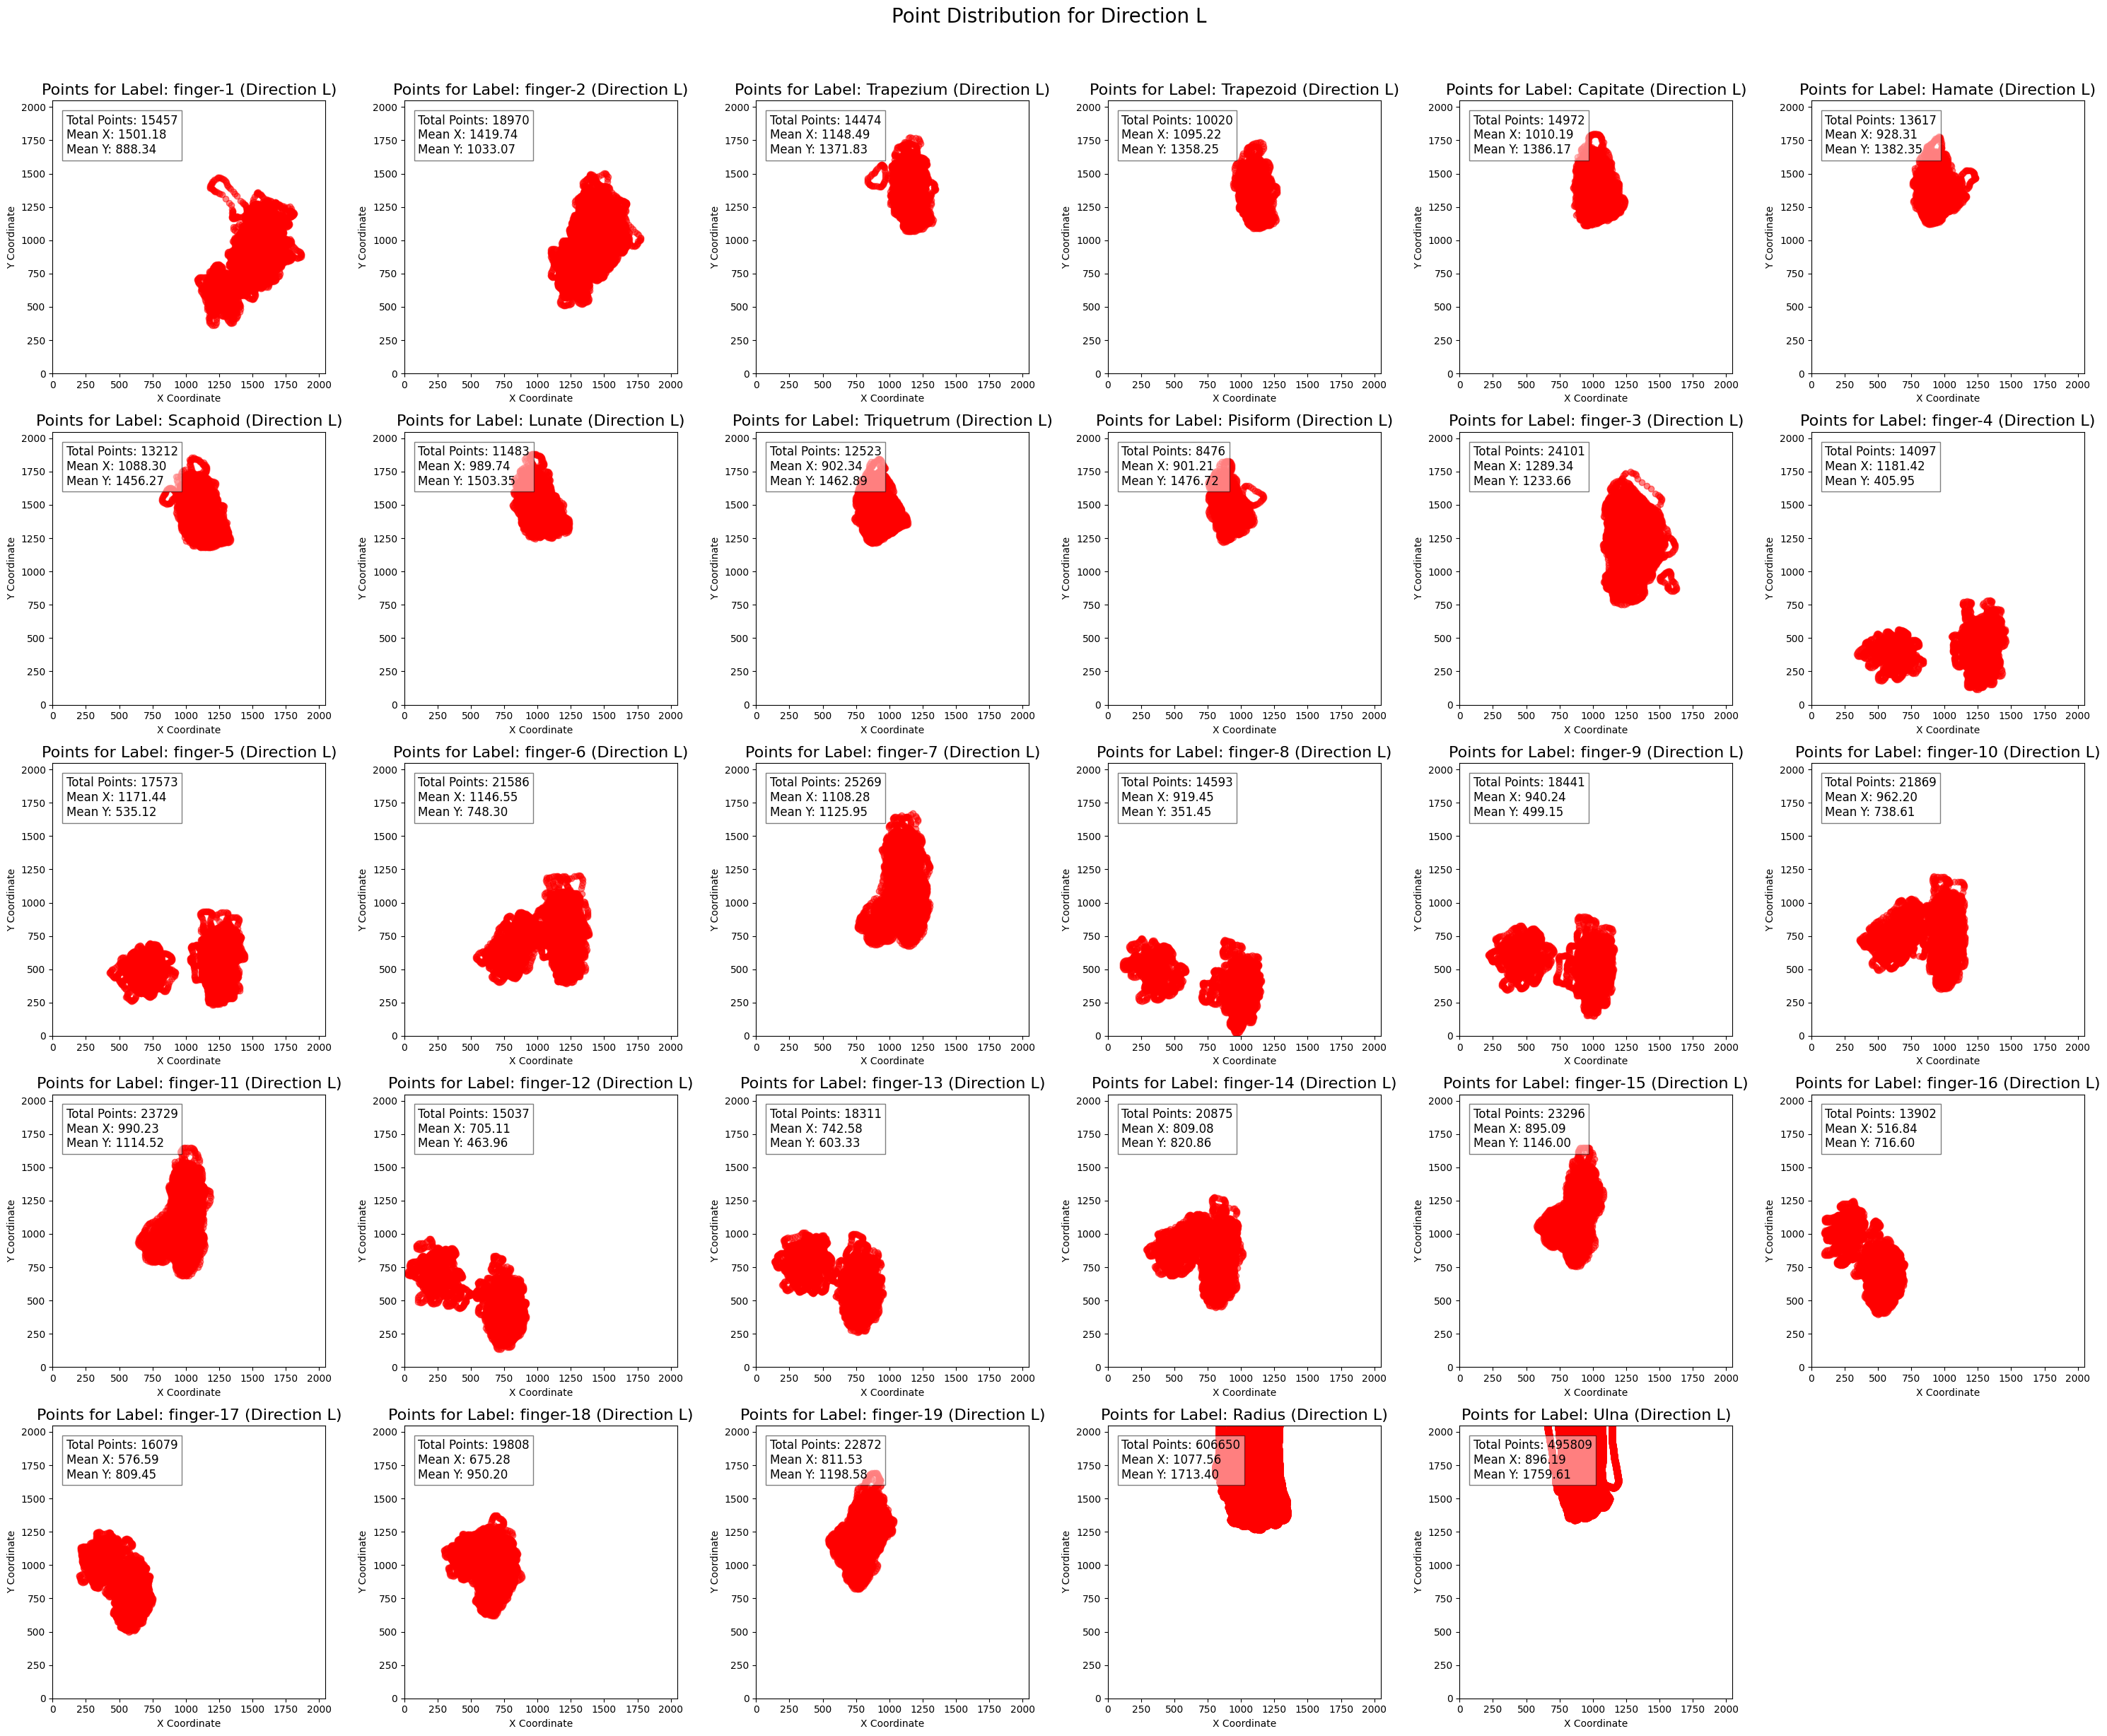

In [12]:
#left
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
from collections import defaultdict

# 데이터 불러오기
df = pd.read_csv("./train_annotation.csv")

# "points"를 리스트 형식으로 변환
df['points'] = df['points'].apply(literal_eval)

# 이미지 크기 설정
image_size = (2048, 2048)

# 레이블별로 L 방향 포인트 저장
label_points_L = defaultdict(list)

# 각 레이블별로 R 방향 포인트 수집
for _, row in df.iterrows():
    points = row['points']
    label = row['label']
    direction = row['direction']
    if direction == 'L':  # L 방향 데이터만 수집
        for point in points:
            label_points_L[label].append(point)

# 서브플롯 설정
num_labels = len(label_points_L)
cols = 6
rows = (num_labels // cols) + (num_labels % cols > 0)  # 필요한 행 수 계산

fig, axes = plt.subplots(rows, cols, figsize=(30, 5 * rows))
axes = axes.flatten()  # 2D 배열을 1D로 변환

# 각 레이블별로 R 방향 점 찍기 및 통계치 출력
for ax, (label, points) in zip(axes, label_points_L.items()):
    ax.set_xlim(0, image_size[0])
    ax.set_ylim(0, image_size[1])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f'Points for Label: {label} (Direction L)', fontsize=16)  # 서브플롯 제목 추가
    
    if points:  # 포인트가 있는 경우에만 점 찍기
        x_coords, y_coords = zip(*points)  # x, y 좌표 분리
        ax.scatter(x_coords, y_coords, color='blue', alpha=0.5)  # 빨간색 점 찍기

    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

    # 통계치 출력
    total_points = len(points)
    mean_x = sum(x_coords) / total_points if total_points > 0 else 0
    mean_y = sum(y_coords) / total_points if total_points > 0 else 0
    ax.text(0.05, 0.95, f'Total Points: {total_points}\nMean X: {mean_x:.2f}\nMean Y: {mean_y:.2f}', 
            transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

# 전체 제목 추가
fig.suptitle('Point Distribution for Direction L', fontsize=20)

# 남은 서브플롯 비우기
for i in range(num_labels, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # 전체 제목을 위한 여백 조정
plt.show()

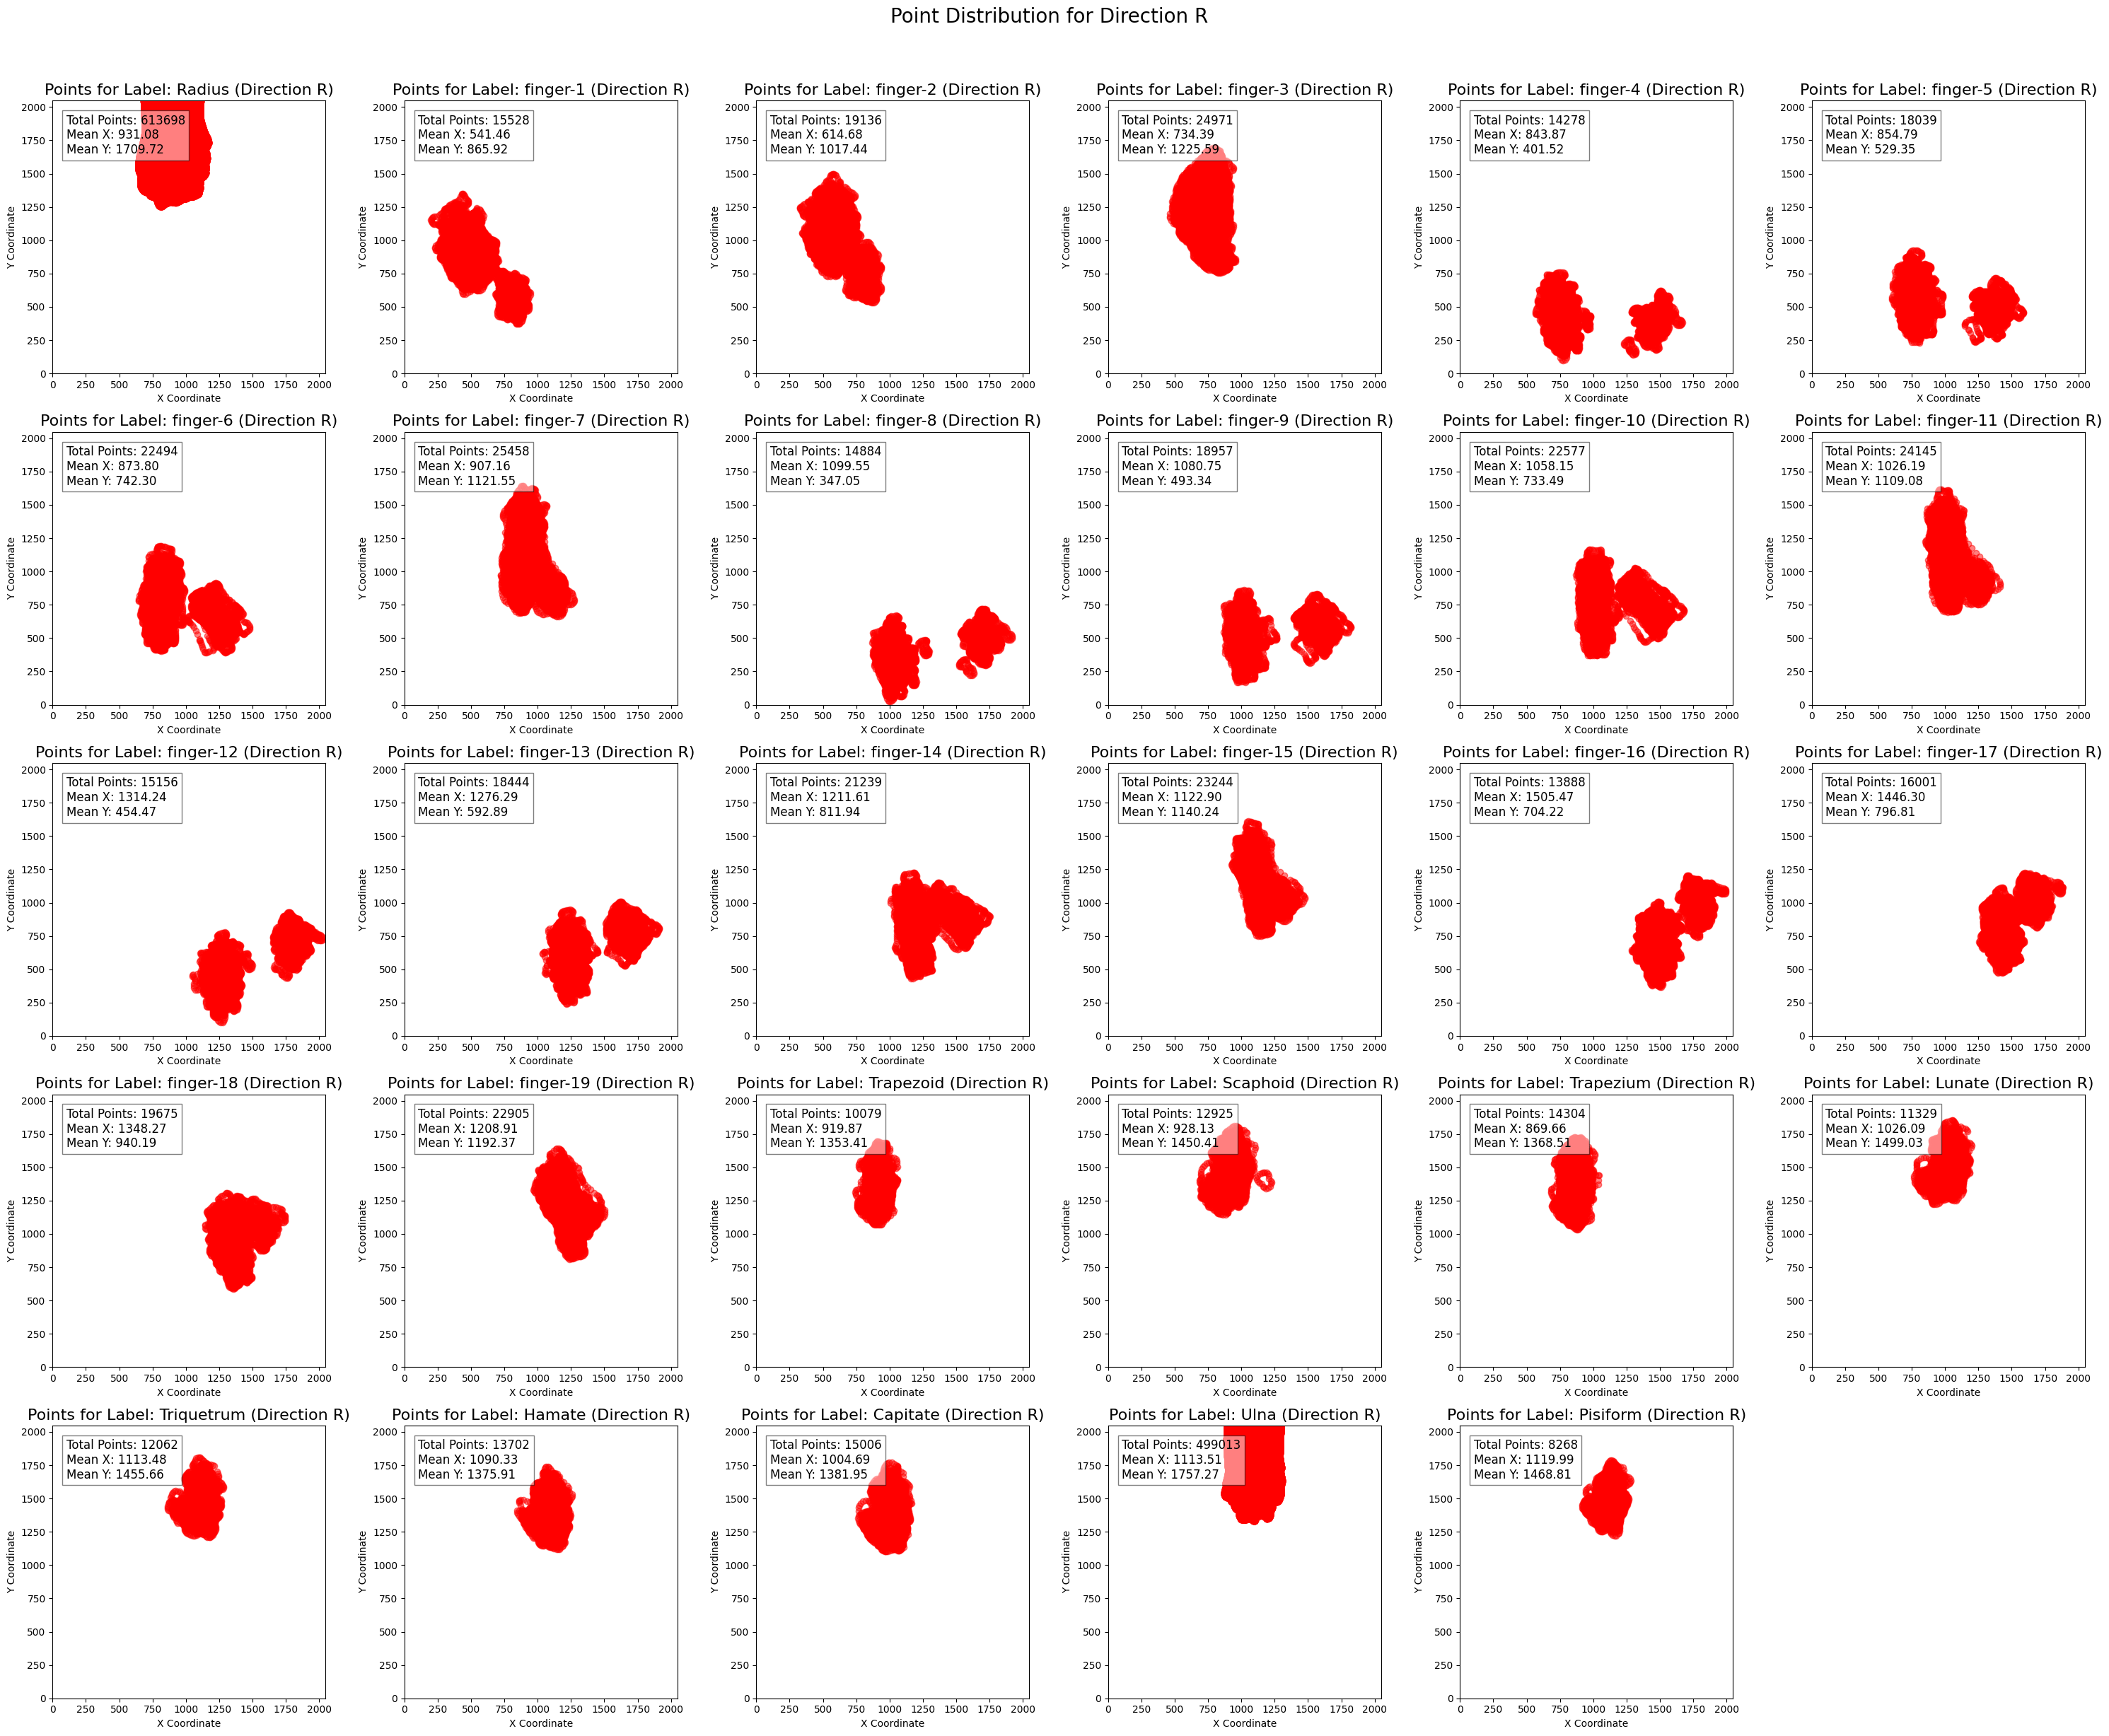

In [13]:
#right
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
from collections import defaultdict

# 데이터 불러오기
df = pd.read_csv("./train_annotation.csv")

# "points"를 리스트 형식으로 변환
df['points'] = df['points'].apply(literal_eval)

# 이미지 크기 설정
image_size = (2048, 2048)

# 레이블별로 R 방향 포인트 저장
label_points_r = defaultdict(list)

# 각 레이블별로 R 방향 포인트 수집
for _, row in df.iterrows():
    points = row['points']
    label = row['label']
    direction = row['direction']
    if direction == 'R':  # R 방향 데이터만 수집
        for point in points:
            label_points_r[label].append(point)

# 서브플롯 설정
num_labels = len(label_points_r)
cols = 6
rows = (num_labels // cols) + (num_labels % cols > 0)  # 필요한 행 수 계산

fig, axes = plt.subplots(rows, cols, figsize=(30, 5 * rows))
axes = axes.flatten()  # 2D 배열을 1D로 변환

# 각 레이블별로 R 방향 점 찍기 및 통계치 출력
for ax, (label, points) in zip(axes, label_points_r.items()):
    ax.set_xlim(0, image_size[0])
    ax.set_ylim(0, image_size[1])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f'Points for Label: {label} (Direction R)', fontsize=16)  # 서브플롯 제목 추가
    
    if points:  # 포인트가 있는 경우에만 점 찍기
        x_coords, y_coords = zip(*points)  # x, y 좌표 분리
        ax.scatter(x_coords, y_coords, color='red', alpha=0.5)  # 빨간색 점 찍기

    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

    # 통계치 출력
    total_points = len(points)
    mean_x = sum(x_coords) / total_points if total_points > 0 else 0
    mean_y = sum(y_coords) / total_points if total_points > 0 else 0
    ax.text(0.05, 0.95, f'Total Points: {total_points}\nMean X: {mean_x:.2f}\nMean Y: {mean_y:.2f}', 
            transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

# 전체 제목 추가
fig.suptitle('Point Distribution for Direction R', fontsize=20)

# 남은 서브플롯 비우기
for i in range(num_labels, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # 전체 제목을 위한 여백 조정
plt.show()

##성별

6322


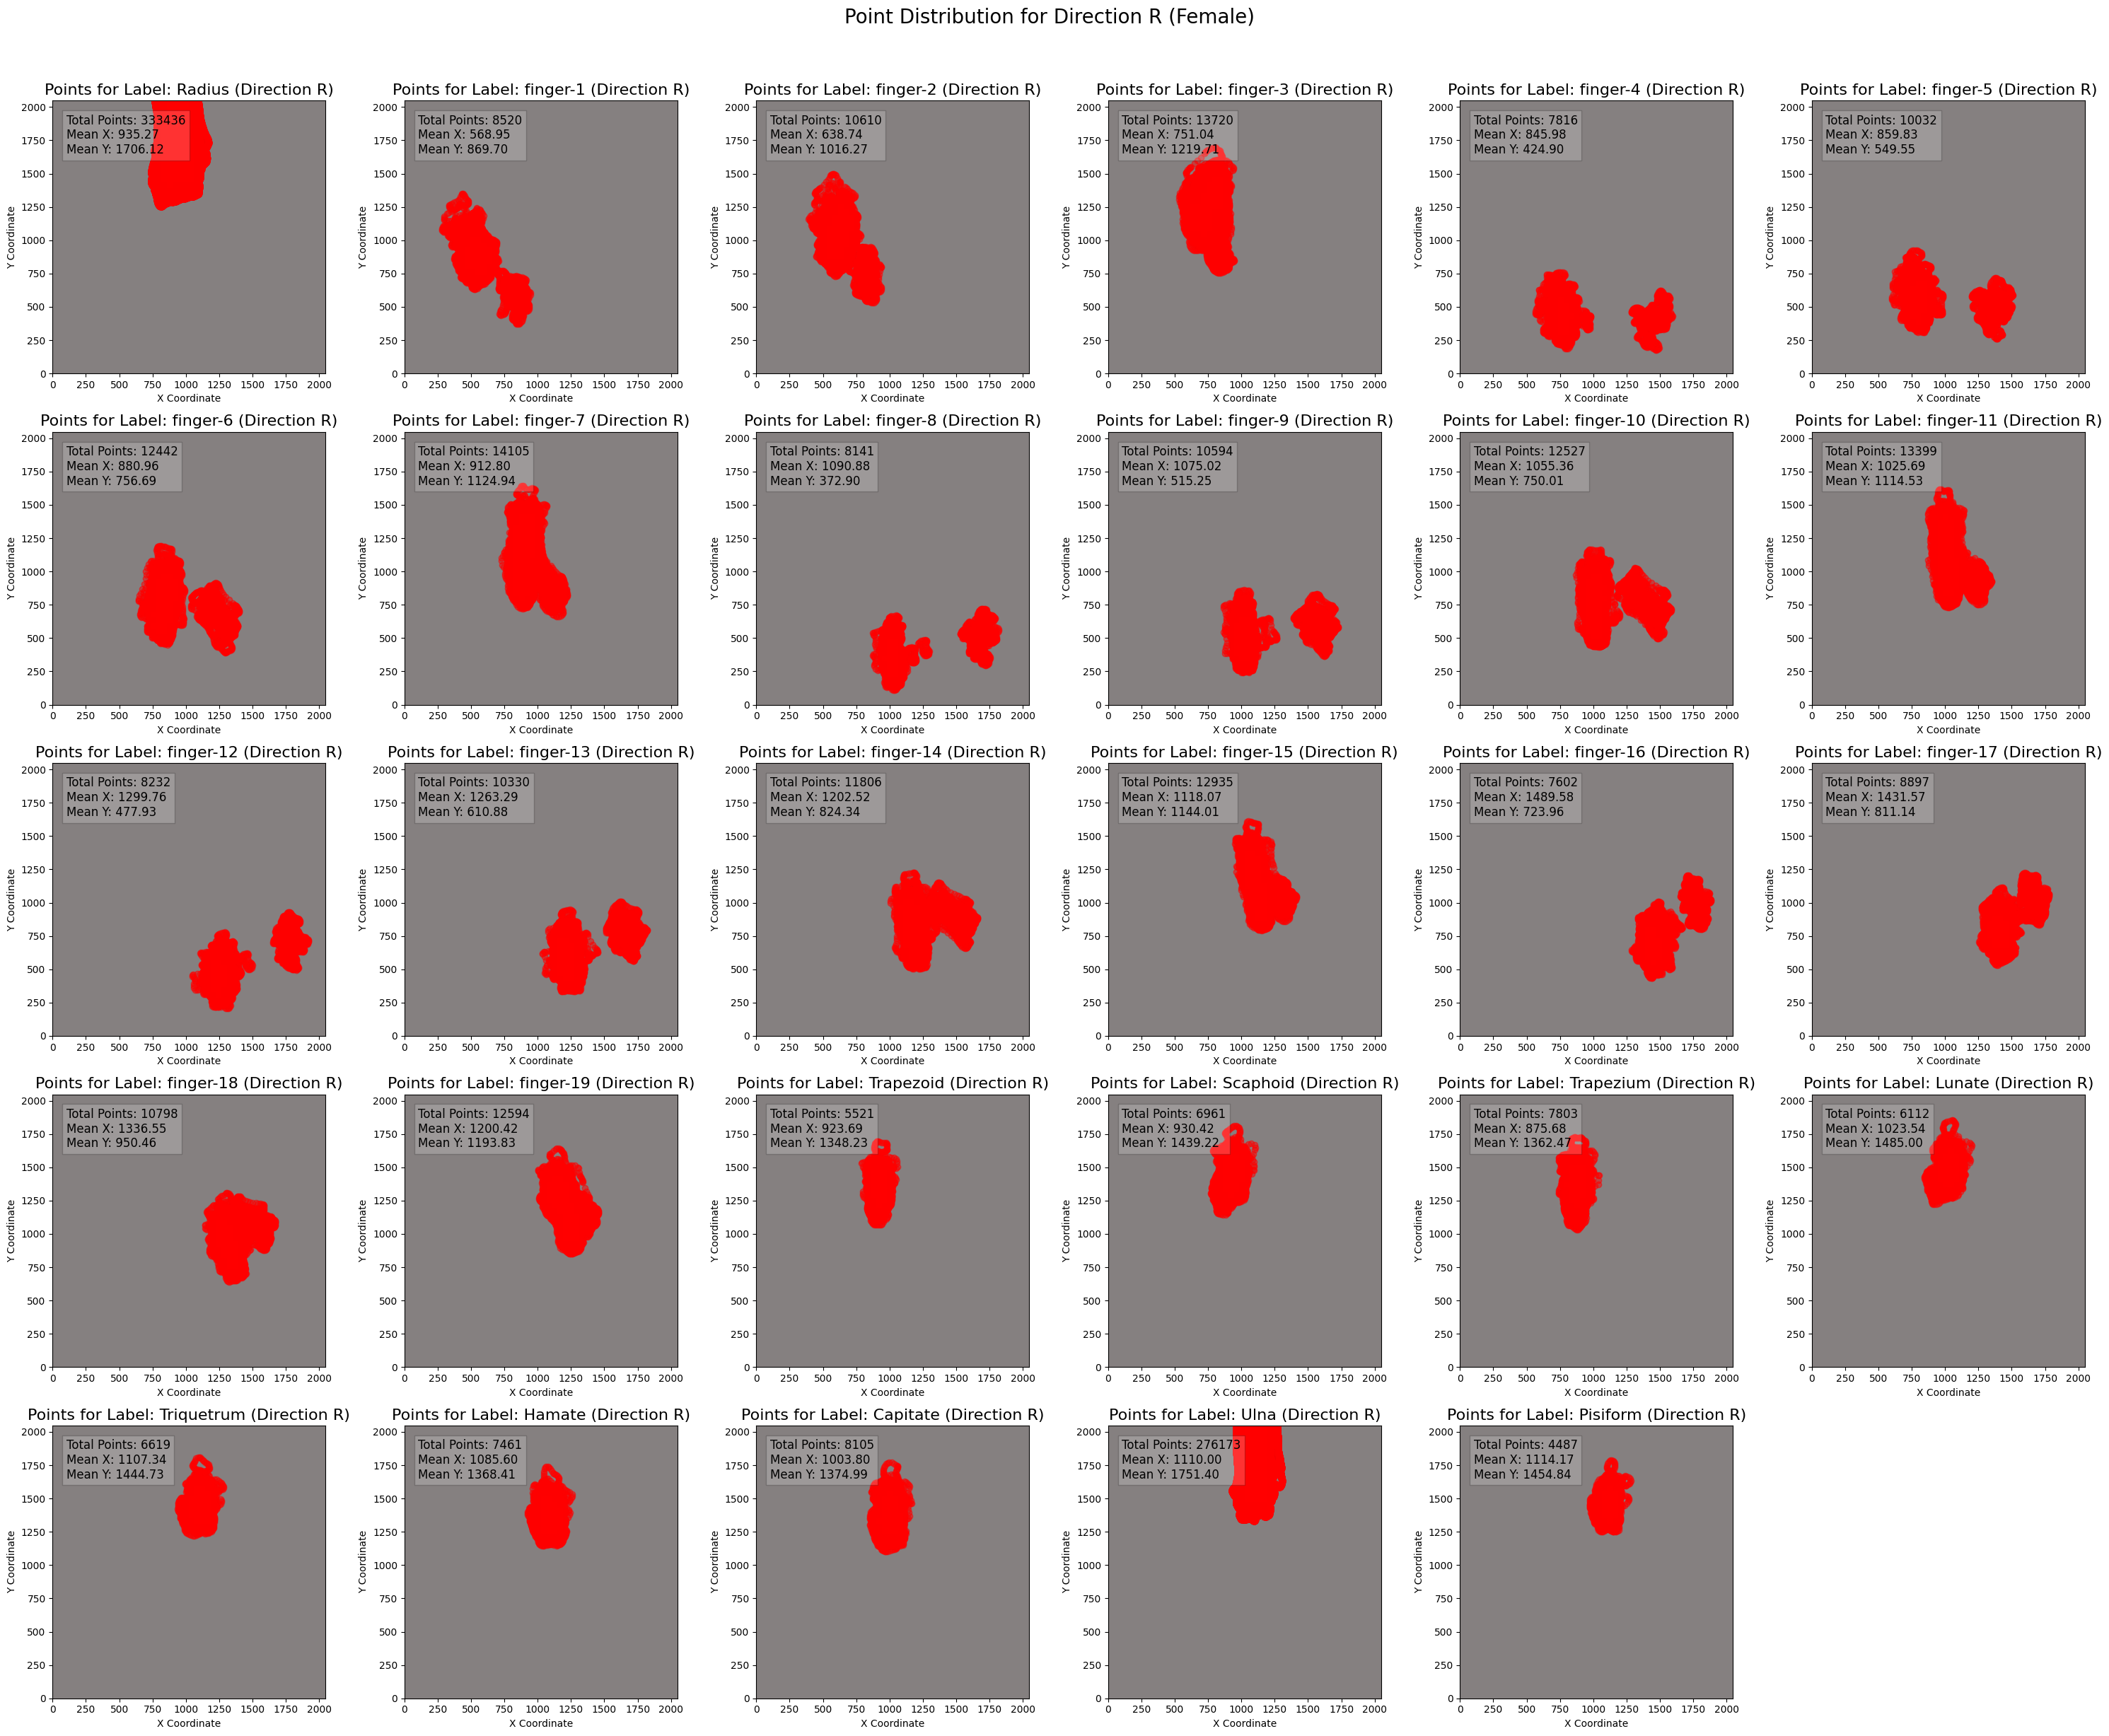

In [30]:
# left hand
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
from collections import defaultdict
import numpy as np

# 데이터 불러오기
df = pd.read_csv("./train_meta.csv")

# "points"를 리스트 형식으로 변환
df['points'] = df['points'].apply(literal_eval)

# "성별"이 "여"인 데이터만 필터링
df_female = df[df['성별'].str.contains("여", na=False)]

# 이미지 크기 설정
image_size = (2048, 2048)

# 레이블별로 R 방향 포인트 저장
label_points_r = defaultdict(list)
count = 0

# 각 레이블별로 R 방향 포인트 수집
for _, row in df_female.iterrows():
    points = row['points']
    label = row['label']
    direction = row['direction']
    if direction == 'R':  # R 방향 데이터만 수집
        count += 1
        for point in points:
            label_points_r[label].append(point)

print(count)

# 서브플롯 설정
num_labels = len(label_points_r)
cols = 6
rows = (num_labels // cols) + (num_labels % cols > 0)  # 필요한 행 수 계산

fig, axes = plt.subplots(rows, cols, figsize=(30, 5 * rows))
axes = axes.flatten()  # 2D 배열을 1D로 변환

# 각 레이블별로 R 방향 점 찍기 및 통계치 출력
for ax, (label, points) in zip(axes, label_points_r.items()):
    ax.set_xlim(0, image_size[0])
    ax.set_ylim(0, image_size[1])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f'Points for Label: {label} (Direction R)', fontsize=16)  # 서브플롯 제목 추가
    
    if points:  # 포인트가 있는 경우에만 점 찍기
        x_coords, y_coords = zip(*points)  # x, y 좌표 분리
        
        # 2D 히스토그램 생성
        heatmap, xedges, yedges = np.histogram2d(x_coords, y_coords, bins=(50, 50), range=[[0, image_size[0]], [0, image_size[1]]])
        
        # 히트맵을 이미지로 표시
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        ax.imshow(heatmap.T, extent=extent, origin='lower', cmap='hot', alpha=0.5)  # 히트맵
        
        # 원래 점도 표시
        ax.scatter(x_coords, y_coords, color='red', alpha=0.5)  # 빨간색 점 찍기

    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

    # 통계치 출력
    total_points = len(points)
    mean_x = sum(x_coords) / total_points if total_points > 0 else 0
    mean_y = sum(y_coords) / total_points if total_points > 0 else 0
    ax.text(0.05, 0.95, f'Total Points: {total_points}\nMean X: {mean_x:.2f}\nMean Y: {mean_y:.2f}', 
            transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.2))

# 전체 제목 추가
fig.suptitle('Point Distribution for Direction R (Female)', fontsize=20)

# 남은 서브플롯 비우기
for i in range(num_labels, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # 전체 제목을 위한 여백 조정
plt.show()

5278


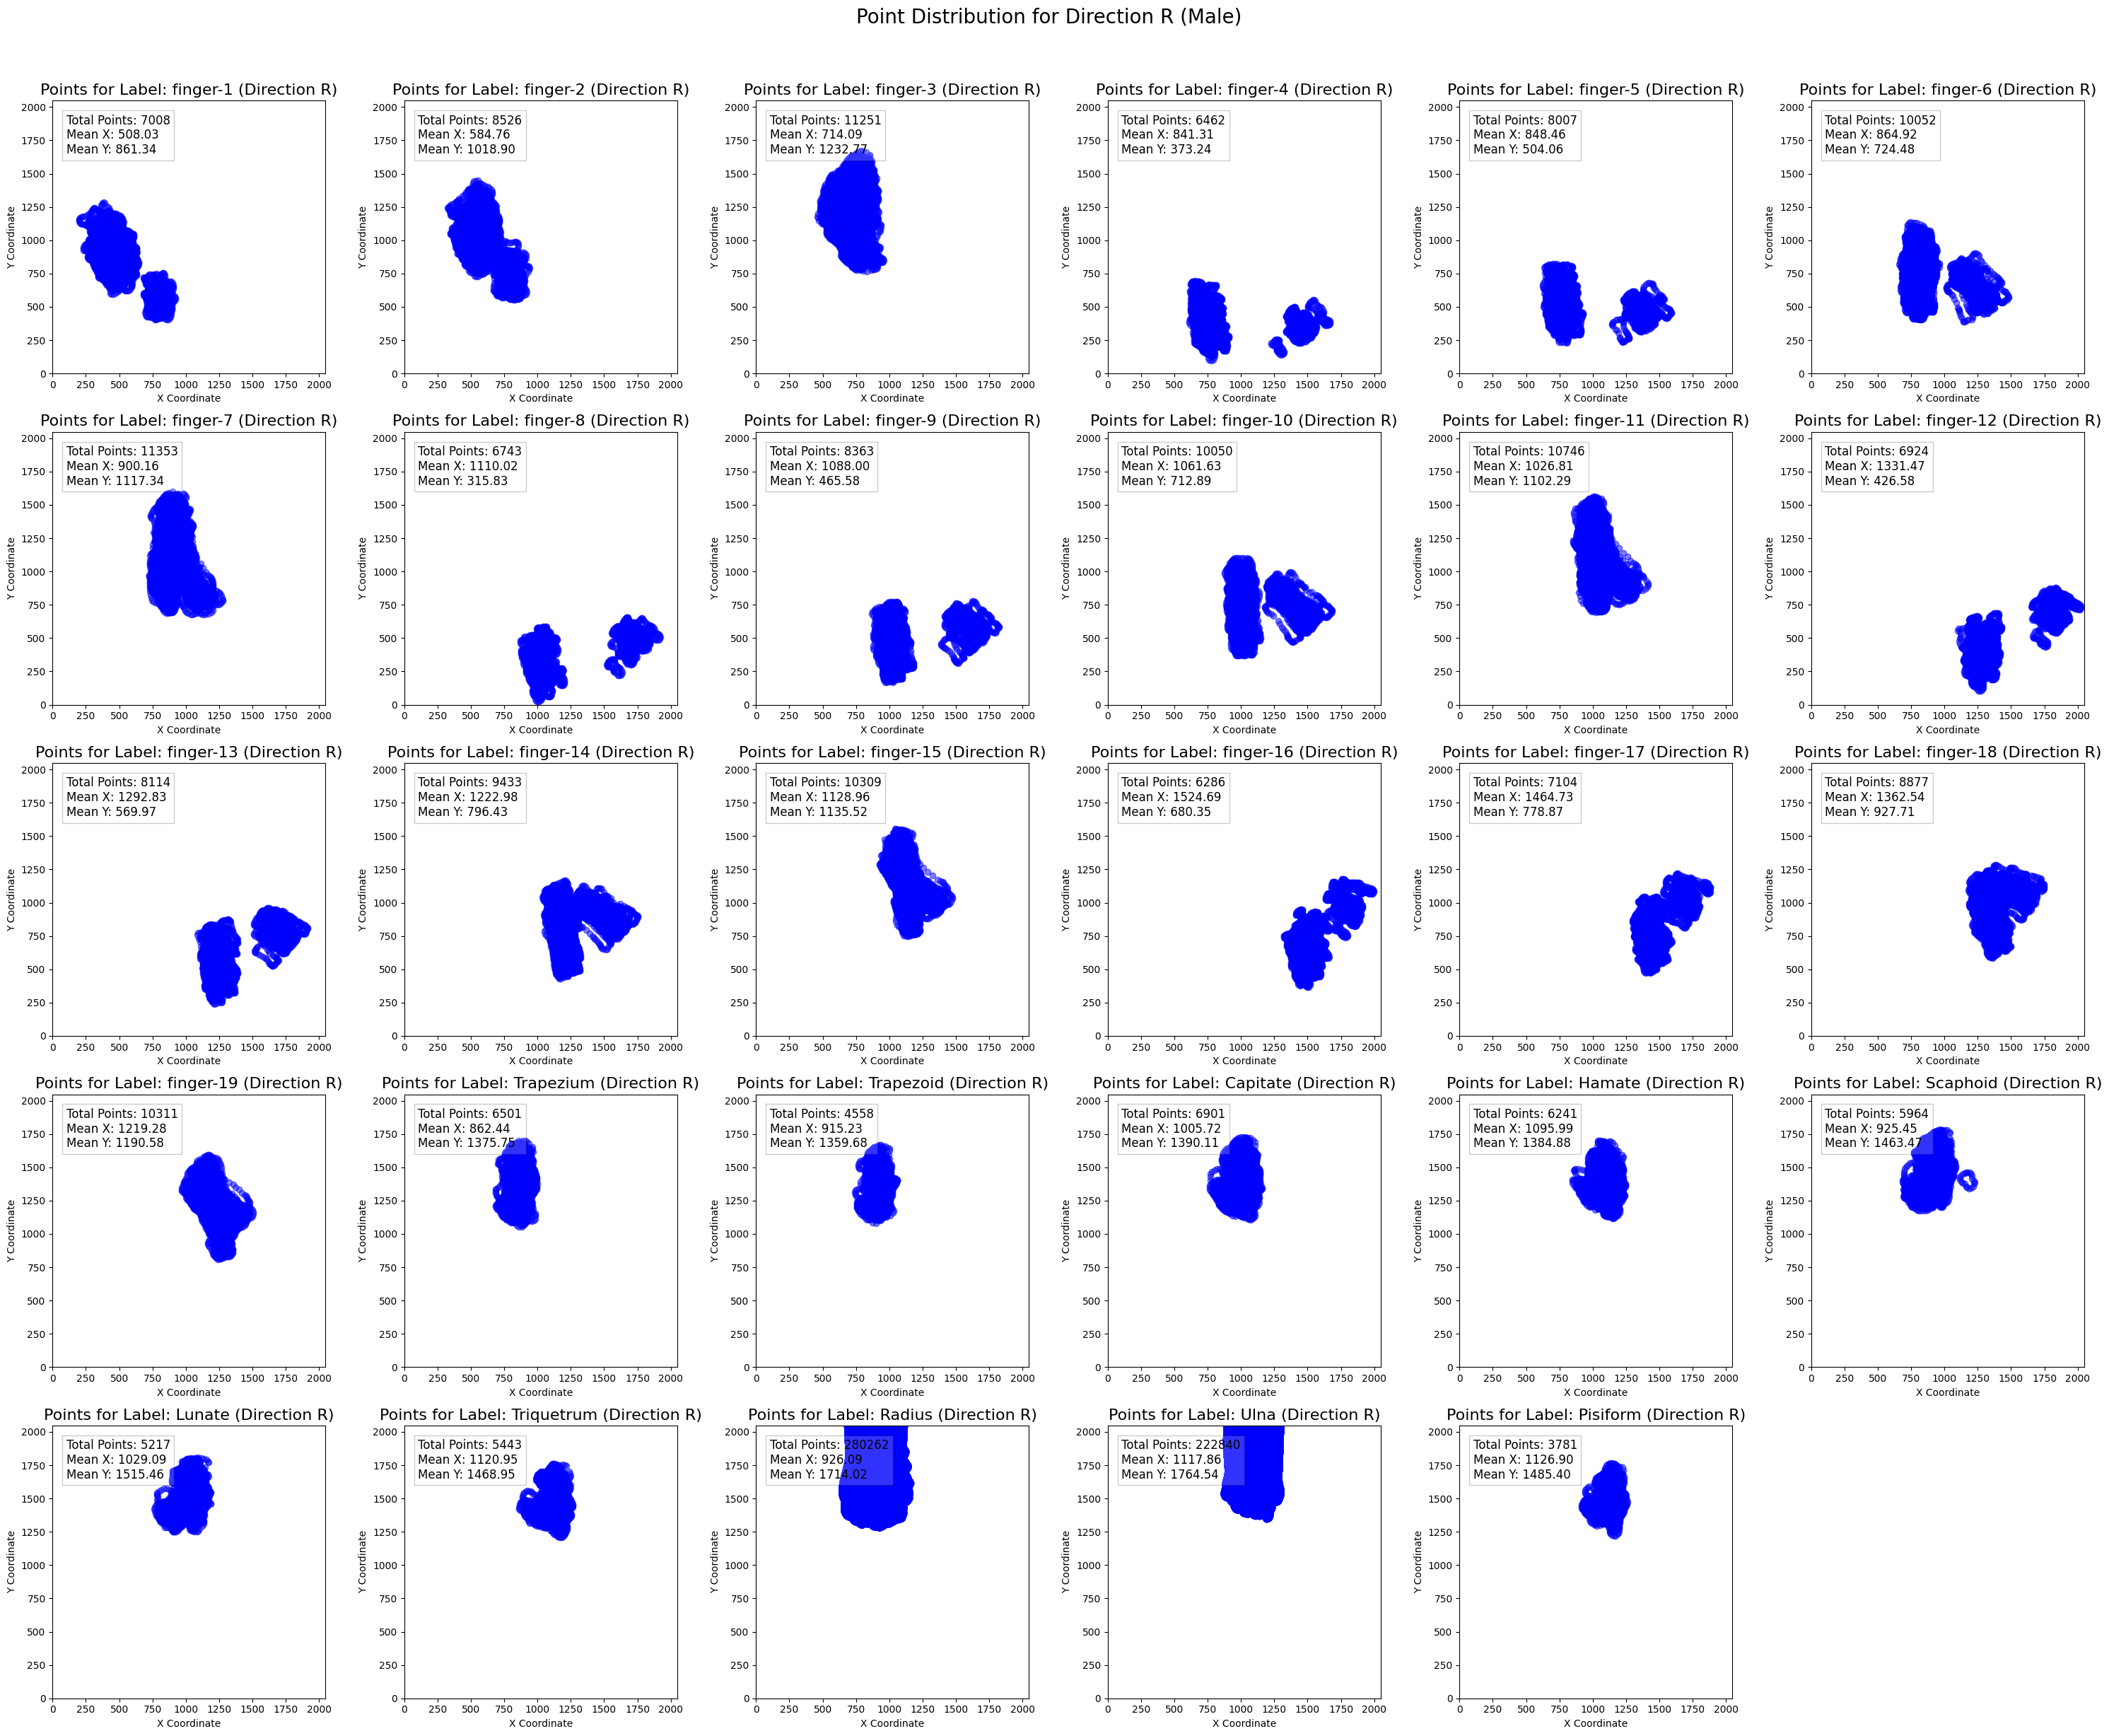

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
from collections import defaultdict

# 데이터 불러오기
df = pd.read_csv("./train_meta.csv")

# "points"를 리스트 형식으로 변환
df['points'] = df['points'].apply(literal_eval)

# "성별"이 "남"인 데이터만 필터링
df_male = df[df['성별'].str.contains("남", na=False)]

# 이미지 크기 설정
image_size = (2048, 2048)

# 레이블별로 R 방향 포인트 저장
label_points_r = defaultdict(list)
count = 0

# 각 레이블별로 R 방향 포인트 수집
for _, row in df_male.iterrows():
    points = row['points']
    label = row['label']
    direction = row['direction']
    if direction == 'R':  # R 방향 데이터만 수집
        count += 1
        for point in points:
            label_points_r[label].append(point)

print(count)

# 서브플롯 설정
num_labels = len(label_points_r)
cols = 6
rows = (num_labels // cols) + (num_labels % cols > 0)  # 필요한 행 수 계산

fig, axes = plt.subplots(rows, cols, figsize=(30, 5 * rows))
axes = axes.flatten()  # 2D 배열을 1D로 변환

# 각 레이블별로 R 방향 점 찍기 및 통계치 출력
for ax, (label, points) in zip(axes, label_points_r.items()):
    ax.set_xlim(0, image_size[0])
    ax.set_ylim(0, image_size[1])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f'Points for Label: {label} (Direction R)', fontsize=16)  # 서브플롯 제목 추가
    
    if points:  # 포인트가 있는 경우에만 점 찍기
        x_coords, y_coords = zip(*points)  # x, y 좌표 분리
        
        # 원래 점을 파란색으로 표시
        ax.scatter(x_coords, y_coords, color='blue', alpha=0.5)  # 파란색 점 찍기

    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

    # 통계치 출력
    total_points = len(points)
    mean_x = sum(x_coords) / total_points if total_points > 0 else 0
    mean_y = sum(y_coords) / total_points if total_points > 0 else 0
    ax.text(0.05, 0.95, f'Total Points: {total_points}\nMean X: {mean_x:.2f}\nMean Y: {mean_y:.2f}', 
            transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.2))

# 전체 제목 추가
fig.suptitle('Point Distribution for Direction R (Male)', fontsize=20)

# 남은 서브플롯 비우기
for i in range(num_labels, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # 전체 제목을 위한 여백 조정
plt.show()

6322


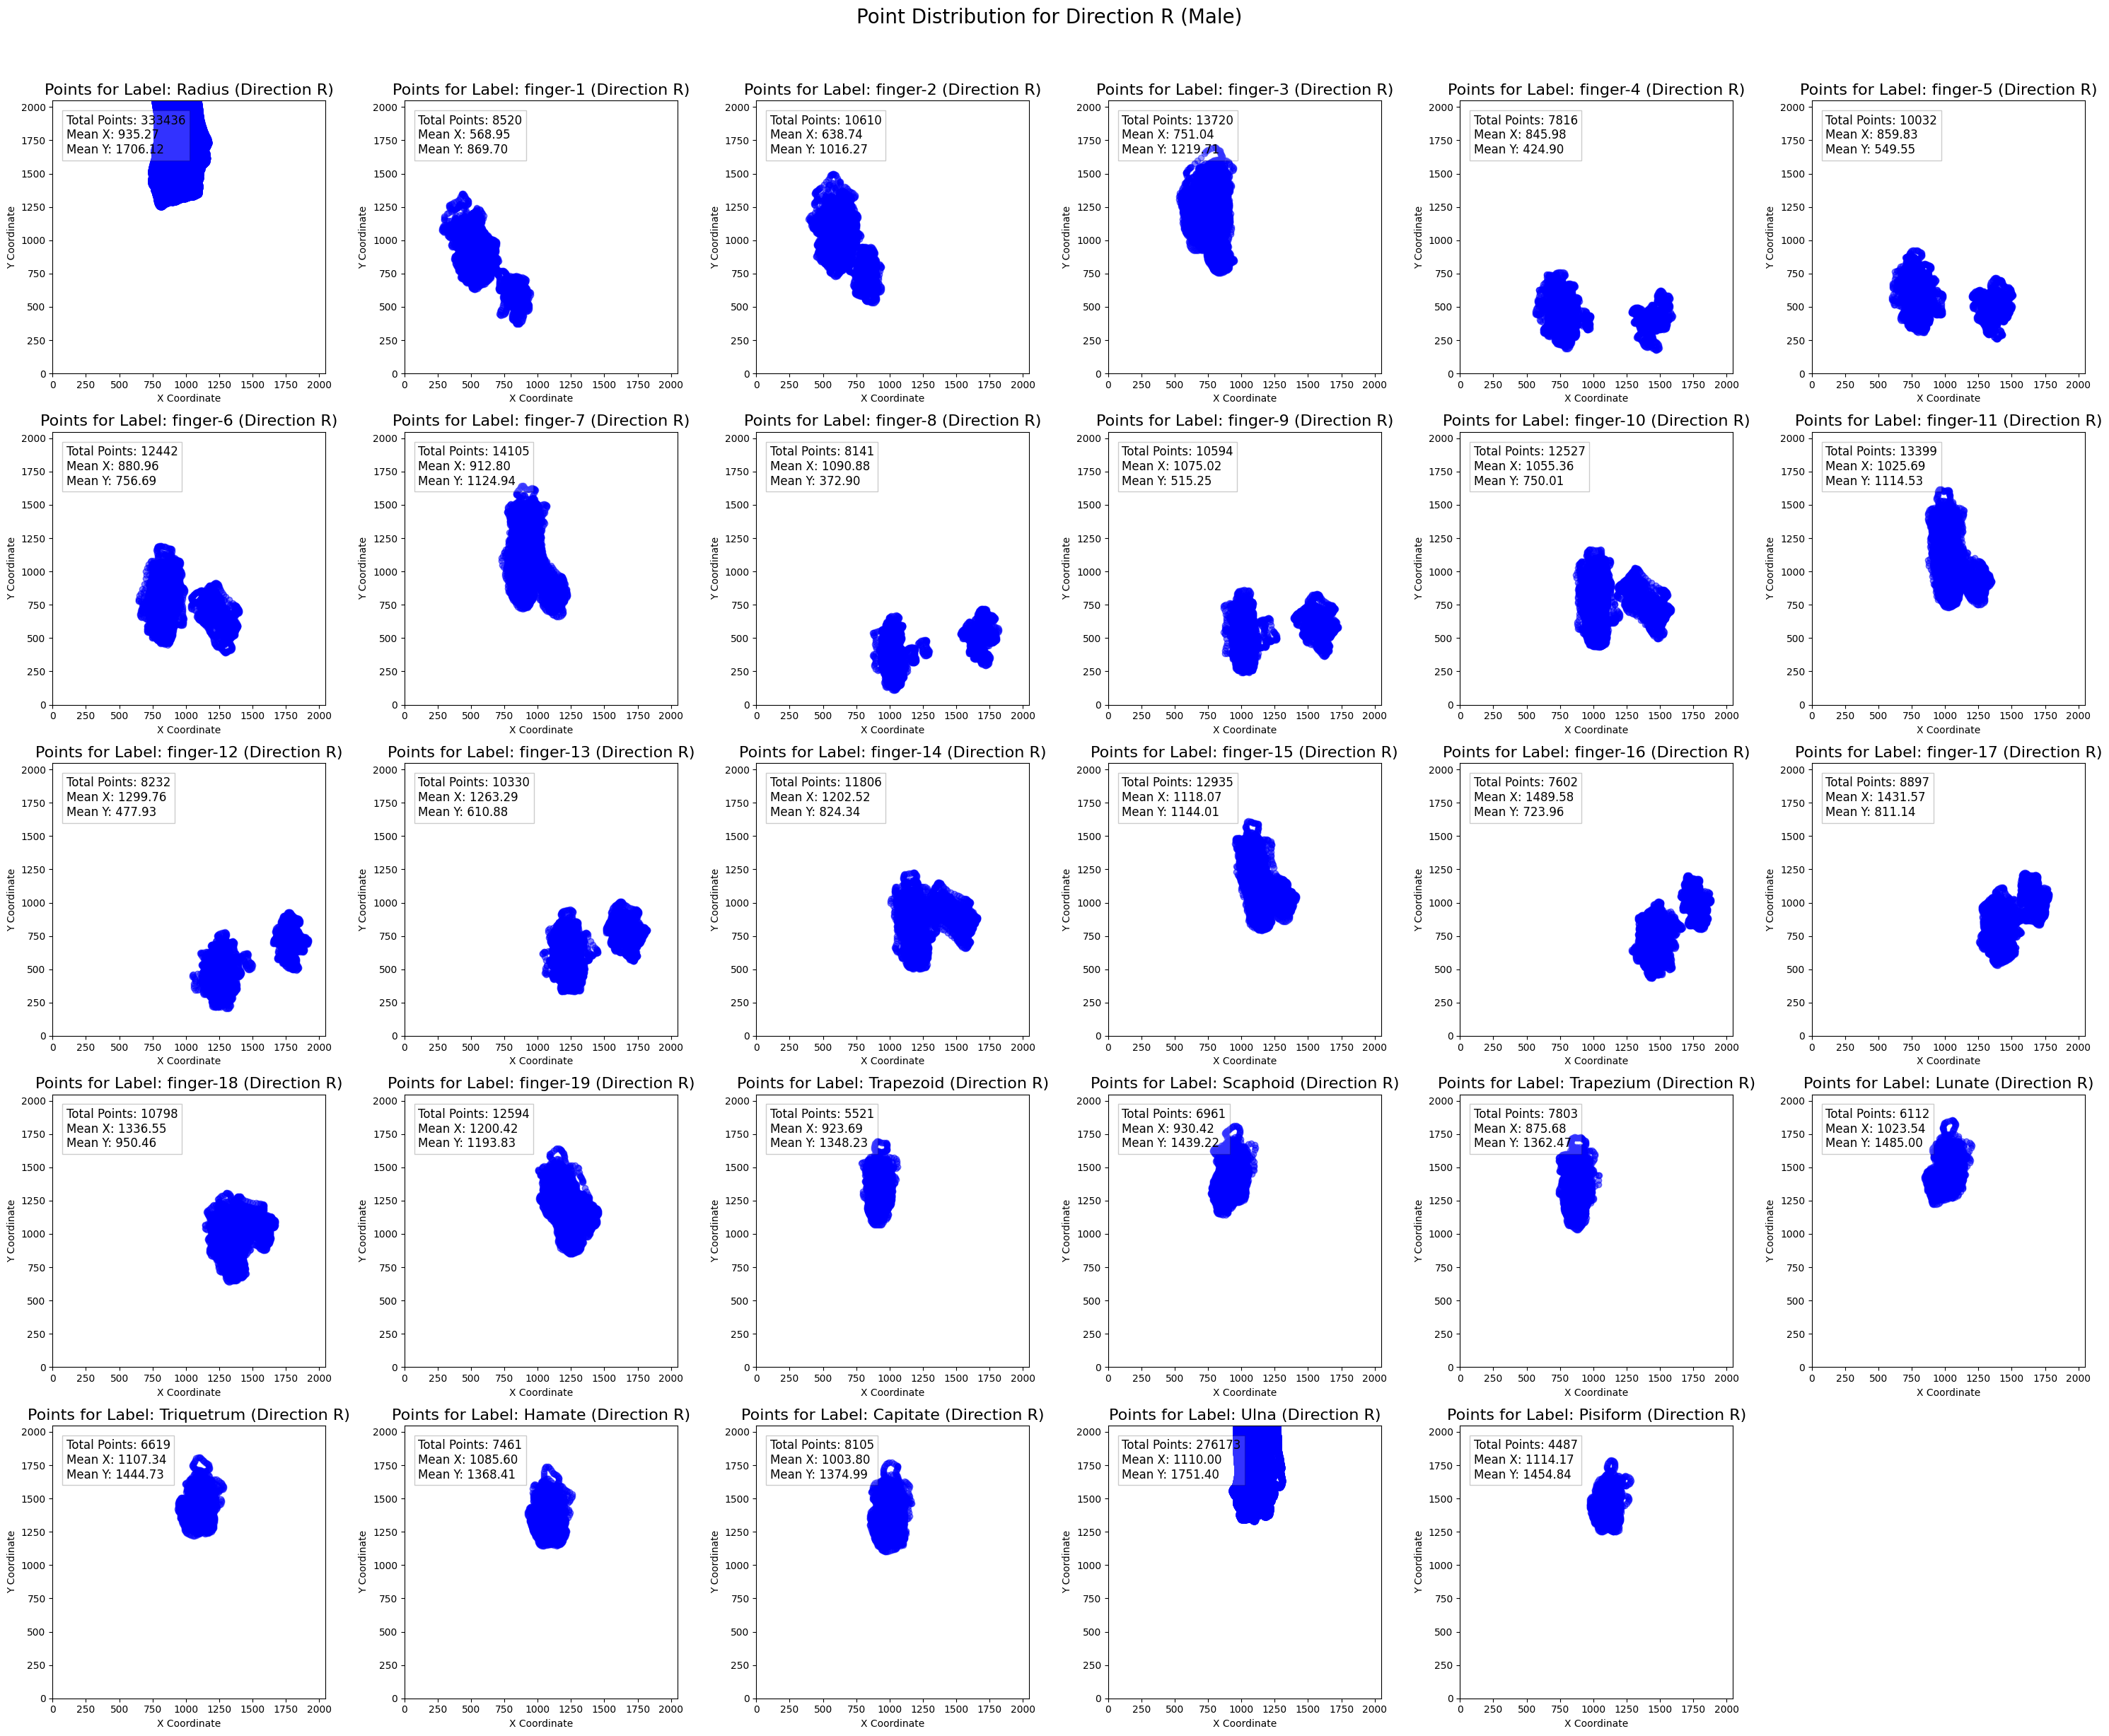

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
from collections import defaultdict

# 데이터 불러오기
df = pd.read_csv("./train_meta.csv")

# "points"를 리스트 형식으로 변환
df['points'] = df['points'].apply(literal_eval)

# "성별"이 "남"인 데이터만 필터링
df_male = df[df['성별'].str.contains("여", na=False)]

# 이미지 크기 설정
image_size = (2048, 2048)

# 레이블별로 R 방향 포인트 저장
label_points_r = defaultdict(list)
count = 0

# 각 레이블별로 R 방향 포인트 수집
for _, row in df_male.iterrows():
    points = row['points']
    label = row['label']
    direction = row['direction']
    if direction == 'R':  # R 방향 데이터만 수집
        count += 1
        for point in points:
            label_points_r[label].append(point)

print(count)

# 서브플롯 설정
num_labels = len(label_points_r)
cols = 6
rows = (num_labels // cols) + (num_labels % cols > 0)  # 필요한 행 수 계산

fig, axes = plt.subplots(rows, cols, figsize=(30, 5 * rows))
axes = axes.flatten()  # 2D 배열을 1D로 변환

# 각 레이블별로 R 방향 점 찍기 및 통계치 출력
for ax, (label, points) in zip(axes, label_points_r.items()):
    ax.set_xlim(0, image_size[0])
    ax.set_ylim(0, image_size[1])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f'Points for Label: {label} (Direction R)', fontsize=16)  # 서브플롯 제목 추가
    
    if points:  # 포인트가 있는 경우에만 점 찍기
        x_coords, y_coords = zip(*points)  # x, y 좌표 분리
        
        # 원래 점을 파란색으로 표시
        ax.scatter(x_coords, y_coords, color='blue', alpha=0.5)  # 파란색 점 찍기

    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

    # 통계치 출력
    total_points = len(points)
    mean_x = sum(x_coords) / total_points if total_points > 0 else 0
    mean_y = sum(y_coords) / total_points if total_points > 0 else 0
    ax.text(0.05, 0.95, f'Total Points: {total_points}\nMean X: {mean_x:.2f}\nMean Y: {mean_y:.2f}', 
            transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.2))

# 전체 제목 추가
fig.suptitle('Point Distribution for Direction R (Male)', fontsize=20)

# 남은 서브플롯 비우기
for i in range(num_labels, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # 전체 제목을 위한 여백 조정
plt.show()

## 1. 모든 train json 내용을 csv 로 합침 
(11.17_new) json을 파일명대로 정렬, 손 방향(dirrection) 정보 추가

##2. # meta 데이터와 train_annotation.csv을 merge


In [6]:
import os
import json
import pandas as pd

# JSON 파일이 저장된 디렉토리 경로
json_dir = './data/train/outputs_json'

# 데이터프레임을 저장할 리스트
data = []


# 디렉토리 내의 모든 환자 ID 폴더를 탐색
for patient_id in sorted(os.listdir(json_dir)):
    patient_path = os.path.join(json_dir, patient_id)
    r_flag= 0 #  0 : R , 1:L
    # 각 환자 ID 폴더 내의 모든 JSON 파일을 탐색
    print(f"#patient_id : {patient_id}")
    for json_file in sorted(os.listdir(patient_path)):
        
        print(f"json_file: {json_file}") 
        if json_file.endswith('.json'):
            file_path = os.path.join(patient_path, json_file)
            direction = "R" if r_flag == 0 else "L"
            # JSON 파일 읽기
            with open(file_path, 'r') as f:
                json_data = json.load(f)
                
                # 필요한 정보 추출
                for annotation in json_data.get('annotations', []):
                    data.append({
                        'patient_id': patient_id,
                        'img_name': json_file.replace('.json', '.png'),
                        'direction':direction,
                        'annotation': annotation,
                        'id': annotation.get('id'),
                        'type': annotation.get('type'),
                        'attributes': annotation.get('attributes'),
                        'points': annotation.get('points'),
                        'label': annotation.get('label', None)  # label이 없을 경우 None으로 설정
                    })
        r_flag += 1 # left



# DataFrame 생성
df = pd.DataFrame(data)
# df.to_csv('./train_annotation.csv', index=False)
df.to_csv('./new_train_annotation.csv', index=False)
print(df.describe)

#patient_id : ID001
json_file: image1661130828152_R.json
json_file: image1661130891365_L.json
#patient_id : ID002
json_file: image1661144206667.json
json_file: image1661144246917.json
#patient_id : ID003
json_file: image1661144310162.json
json_file: image1661144351691.json
#patient_id : ID004
json_file: image1661144691792.json
json_file: image1661144724044.json
#patient_id : ID005
json_file: image1661144825412.json
json_file: image1661144852117.json
#patient_id : ID006
json_file: image1661145075929.json
json_file: image1661145103549.json
#patient_id : ID007
json_file: image1661145193855.json
json_file: image1661145229731.json
#patient_id : ID008
json_file: image1661145286692.json
json_file: image1661145313061.json
#patient_id : ID009
json_file: image1661145407161.json
json_file: image1661145432967.json
#patient_id : ID010
json_file: image1661145563354.json
json_file: image1661145591320.json
#patient_id : ID011
json_file: image1661146664360.json
json_file: image1661146685158.json
#patie

In [25]:
train_df = pd.read_csv("./train_annotation.csv")
meta_df = pd.read_excel("./data/meta_data.xlsx")

print(train_df.info())
print(meta_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23200 entries, 0 to 23199
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  23200 non-null  object
 1   img_name    23200 non-null  object
 2   direction   23200 non-null  object
 3   annotation  23200 non-null  object
 4   id          23200 non-null  object
 5   type        23200 non-null  object
 6   attributes  23200 non-null  object
 7   points      23200 non-null  object
 8   label       23200 non-null  object
dtypes: object(9)
memory usage: 1.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          550 non-null    int64  
 1   나이          550 non-null    int64  
 2   성별          550 non-null    object 
 3   체중(몸무게)     550 non-null    float64
 4   키(신장)       550 non-null    float64
 5   Unnamed: 5 

In [24]:
import pandas as pd

# 데이터 불러오기
train_df = pd.read_csv("./train_annotation.csv")
meta_df = pd.read_excel("./data/meta_data.xlsx")

# patient_id에서 "ID"를 제거하고 숫자 부분만 추출
train_df['ID'] = train_df['patient_id'].str.replace('ID', '', regex=False)

# ID 값을 정수형으로 변환
train_df['ID'] = train_df['ID'].astype(int)

# meta_df의 ID에 "ID"를 붙여서 새로운 열 생성 (주석 처리된 부분은 필요에 따라 사용)
# meta_df['patient_id'] = 'ID' + meta_df['ID'].astype(str)

# 병합 수행
merged_df = pd.merge(train_df, meta_df, on='ID', how='left')

# 결과 출력
print(merged_df.info())
print(merged_df.head())
merged_df.to_csv("./new_train_meta.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23200 entries, 0 to 23199
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   patient_id  23200 non-null  object 
 1   img_name    23200 non-null  object 
 2   direction   23200 non-null  object 
 3   annotation  23200 non-null  object 
 4   id          23200 non-null  object 
 5   type        23200 non-null  object 
 6   attributes  23200 non-null  object 
 7   points      23200 non-null  object 
 8   label       23200 non-null  object 
 9   ID          23200 non-null  int64  
 10  나이          23200 non-null  int64  
 11  성별          23200 non-null  object 
 12  체중(몸무게)     23200 non-null  float64
 13  키(신장)       23200 non-null  float64
 14  Unnamed: 5  58 non-null     object 
dtypes: float64(2), int64(2), object(11)
memory usage: 2.7+ MB
None
  patient_id                  img_name direction  \
0      ID001  image1661130828152_R.png         R   
1      ID001  image166

# 손목 기울어진 이미지 개수 확인 

/tmp/ipykernel_747659/977918077.py:59: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(mean_x, mean_y, color=colors[i % len(colors)], edgecolor='black', marker='x', s=100, label=f'Center {label}')


Cluster 0 boundaries: x_min=702, x_max=1296, y_min=20, y_max=719
Cluster 1 boundaries: x_min=1521, x_max=1921, y_min=220, y_max=721
Cluster 2 boundaries: x_min=113, x_max=585, y_min=261, y_max=732


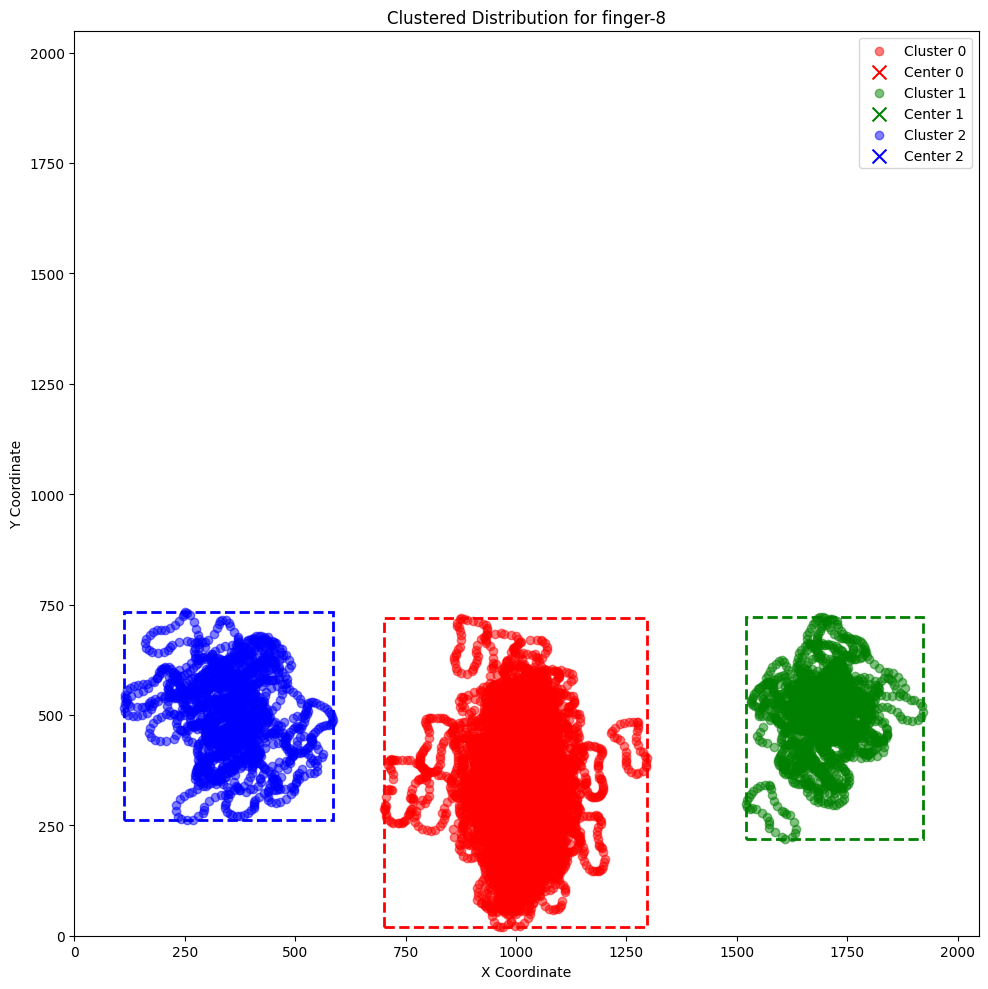

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
from collections import defaultdict
import numpy as np
from sklearn.cluster import DBSCAN

# 데이터 불러오기
df = pd.read_csv("./train_annotation.csv")

# "points"를 리스트 형식으로 변환
df['points'] = df['points'].apply(literal_eval)

# 이미지 크기 설정
image_size = (2048, 2048)

# 레이블별로 포인트 저장
label_points = defaultdict(list)

# 각 레이블별로 포인트 수집
for _, row in df.iterrows():
    points = row['points']
    label = row['label']
    for point in points:
        label_points[label].append(point)

# DBSCAN 군집화 함수
def cluster_points(points, eps=100, min_samples=5):
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
    labels = db.labels_
    clusters = defaultdict(list)
    for point, label in zip(points, labels):
        if label != -1:  # -1은 noise 포인트
            clusters[label].append(point)
    return clusters

# 특정 레이블(finger-8)에 대해 DBSCAN 적용 및 결과 시각화
target_label = 'finger-8'
points = np.array(label_points[target_label])  # finger-8의 좌표 배열화

# DBSCAN 군집화 수행
clusters = cluster_points(points)

# 시각화
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(0, image_size[0])
ax.set_ylim(0, image_size[1])
ax.set_aspect('equal', adjustable='box')
ax.set_title(f'Clustered Points for Label: {target_label}')

# 각 군집의 포인트와 중심을 표시
colors = ['red', 'green', 'blue']
for i, (label, cluster_points) in enumerate(clusters.items()):
    cluster_points = np.array(cluster_points)
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[i % len(colors)], label=f'Cluster {label}', alpha=0.5)

    # 군집의 중심 계산
    mean_x, mean_y = cluster_points.mean(axis=0)
    ax.scatter(mean_x, mean_y, color=colors[i % len(colors)], edgecolor='black', marker='x', s=100, label=f'Center {label}')
    
    # 경계 계산 및 표시
    x_min, y_min = cluster_points.min(axis=0)
    x_max, y_max = cluster_points.max(axis=0)
    ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, edgecolor=colors[i % len(colors)], linewidth=2, linestyle='--'))

    # 경계 값 출력
    print(f'Cluster {label} boundaries: x_min={x_min}, x_max={x_max}, y_min={y_min}, y_max={y_max}')

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.legend()
plt.title(f"Clustered Distribution for {target_label}")
plt.tight_layout()
plt.show()

In [2]:
#cluster에 따른 RL 분리
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.cluster import DBSCAN

# 데이터 불러오기
df = pd.read_csv("./train_annotation.csv")
df['points'] = df['points'].apply(literal_eval)

# 특정 레이블(finger-8)에 대한 데이터 필터링
finger8_df = df[df['label'] == 'finger-8'].copy()

# 개별 좌표로 확장
expanded_points = []
for _, row in finger8_df.iterrows():
    for point in row['points']:
        expanded_points.append((row['img_name'], row['direction'], point[0], point[1]))

expanded_df = pd.DataFrame(expanded_points, columns=['img_name', 'direction', 'x', 'y'])

# DBSCAN 군집화 수행
db = DBSCAN(eps=100, min_samples=5).fit(expanded_df[['x', 'y']])
expanded_df['cluster'] = db.labels_

# 각 군집에 따른 파트 명칭 할당
part_names = {0: 'Center', 1: 'Right', 2: 'Left'} # Right hand - cetner , right / left hand : center , left
expanded_df['shift'] = expanded_df['cluster'].map(part_names)

# 필요한 정보만 포함한 최종 데이터프레임 생성
final_df = expanded_df[['img_name', 'direction', 'shift']].drop_duplicates().reset_index(drop=True)

# 각 part의 종류에 따른 중복 개수 세기
part_counts = final_df['shift'].value_counts()

# direction이 L인 데이터와 R인 데이터로 분리
left_df = final_df[final_df['direction'] == 'L']
right_df = final_df[final_df['direction'] == 'R']

# 각 direction별 part의 중복 개수 세기
left_part_counts = left_df['shift'].value_counts()
right_part_counts = right_df['shift'].value_counts()

# 결과 출력
print('전체 데이터')
print(part_counts)
print("왼쪽 손 (Left) part 개수:")
print(left_part_counts)

print("\n오른쪽 손(Right) part 개수:")
print(right_part_counts)

final_df.to_csv("./new_train_")


전체 데이터
shift
Center    706
Right      47
Left       47
Name: count, dtype: int64
왼쪽 손 (Left) part 개수:
shift
Center    353
Left       47
Name: count, dtype: int64

오른쪽 손(Right) part 개수:
shift
Center    353
Right      47
Name: count, dtype: int64


## Right hand - finger-8 cluster - right(c1) , Left hand - left shift (c2)

/tmp/ipykernel_747659/1149599817.py:60: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(mean_x, mean_y, color=colors[i % len(colors)], edgecolor='black', marker='x', s=100, label=f'Center {label}')


Cluster 0 boundaries: x_min=870, x_max=1296, y_min=23, y_max=670
Cluster 1 boundaries: x_min=1521, x_max=1921, y_min=220, y_max=721


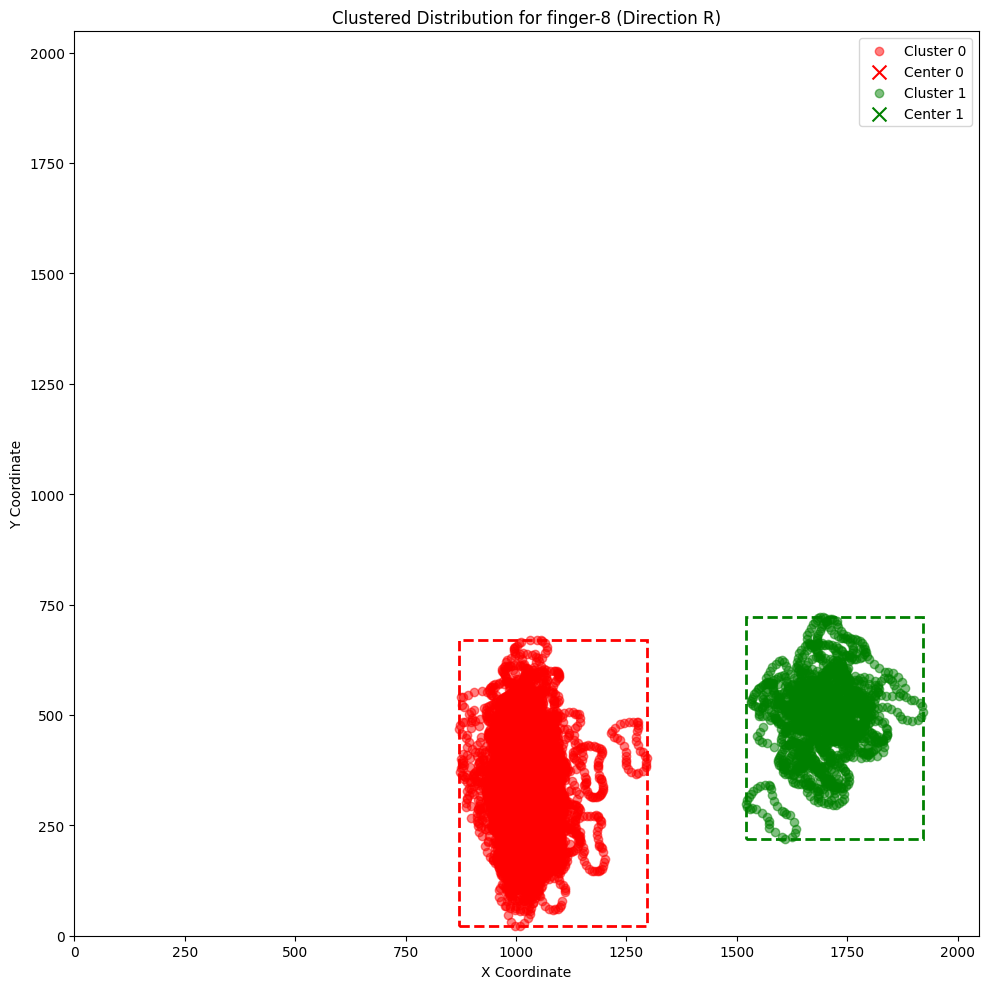

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
from collections import defaultdict
import numpy as np
from sklearn.cluster import DBSCAN

# 데이터 불러오기
df = pd.read_csv("./train_annotation.csv")

# "points"를 리스트 형식으로 변환
df['points'] = df['points'].apply(literal_eval)

# 이미지 크기 설정
image_size = (2048, 2048)

# 특정 레이블(finger-8)에 대한 데이터 필터링 및 direction이 "R"인 경우만 선택
finger8_df = df[(df['label'] == 'finger-8') & (df['direction'] == 'R')].copy()

# 레이블별로 포인트 저장
label_points = defaultdict(list)

# 각 레이블별로 포인트 수집
for _, row in finger8_df.iterrows():
    points = row['points']
    for point in points:
        label_points['finger-8'].append(point)

# DBSCAN 군집화 함수
def cluster_points(points, eps=100, min_samples=5):
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
    labels = db.labels_
    clusters = defaultdict(list)
    for point, label in zip(points, labels):
        if label != -1:  # -1은 noise 포인트
            clusters[label].append(point)
    return clusters

# finger-8의 좌표 배열화
points = np.array(label_points['finger-8'])

# DBSCAN 군집화 수행
clusters = cluster_points(points)

# 시각화
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(0, image_size[0])
ax.set_ylim(0, image_size[1])
ax.set_aspect('equal', adjustable='box')
ax.set_title(f'Clustered Points for Label: finger-8 (Direction R)')

# 각 군집의 포인트와 중심을 표시
colors = ['red', 'green', 'blue']
for i, (label, cluster_points) in enumerate(clusters.items()):
    cluster_points = np.array(cluster_points)
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[i % len(colors)], label=f'Cluster {label}', alpha=0.5)

    # 군집의 중심 계산
    mean_x, mean_y = cluster_points.mean(axis=0)
    ax.scatter(mean_x, mean_y, color=colors[i % len(colors)], edgecolor='black', marker='x', s=100, label=f'Center {label}')
    
    # 경계 계산 및 표시
    x_min, y_min = cluster_points.min(axis=0)
    x_max, y_max = cluster_points.max(axis=0)
    ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, edgecolor=colors[i % len(colors)], linewidth=2, linestyle='--'))

    # 경계 값 출력
    print(f'Cluster {label} boundaries: x_min={x_min}, x_max={x_max}, y_min={y_min}, y_max={y_max}')

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.legend()
plt.title(f"Clustered Distribution for finger-8 (Direction R)")
plt.tight_layout()
plt.show()

/tmp/ipykernel_747659/815453219.py:60: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(mean_x, mean_y, color=colors[i % len(colors)], edgecolor='black', marker='x', s=100, label=f'Center {label}')


Cluster 0 boundaries: x_min=702, x_max=1153, y_min=20, y_max=719
Cluster 1 boundaries: x_min=113, x_max=585, y_min=261, y_max=732


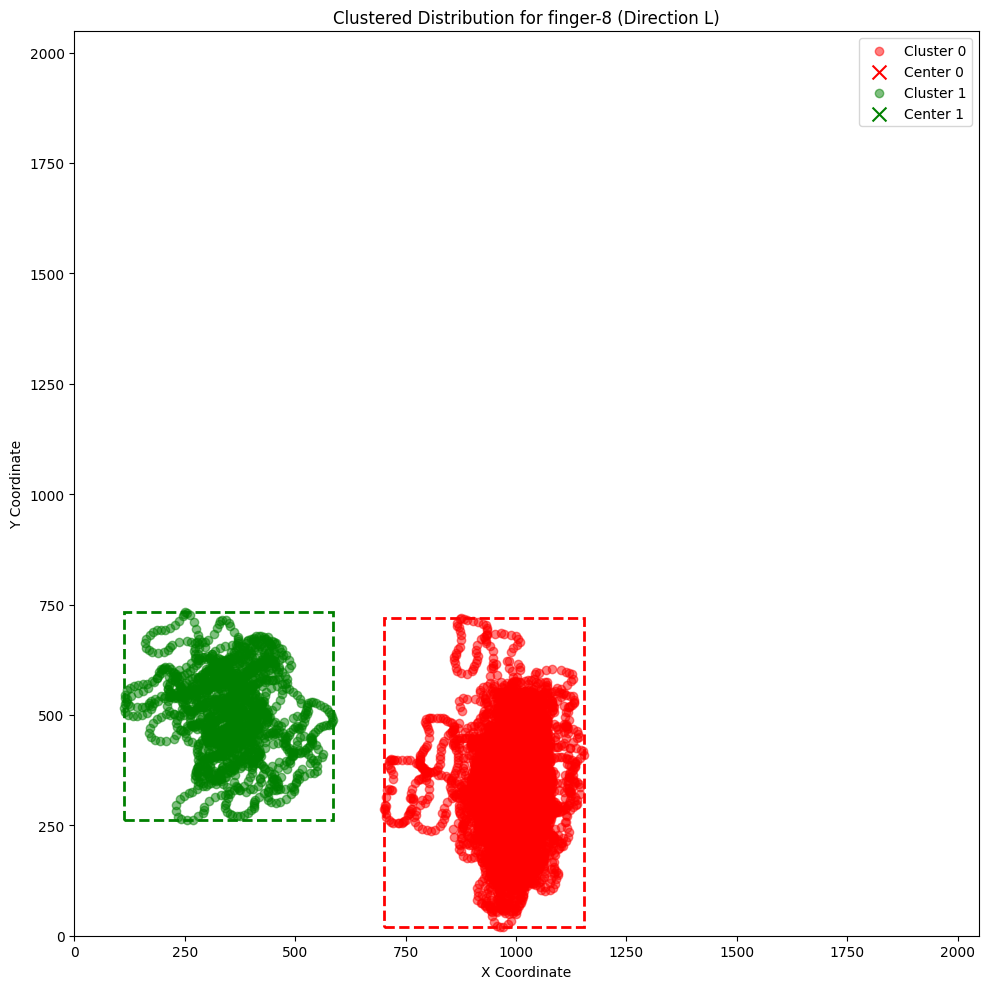

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
from collections import defaultdict
import numpy as np
from sklearn.cluster import DBSCAN

# 데이터 불러오기
df = pd.read_csv("./train_annotation.csv")

# "points"를 리스트 형식으로 변환
df['points'] = df['points'].apply(literal_eval)

# 이미지 크기 설정
image_size = (2048, 2048)

# 특정 레이블(finger-8)에 대한 데이터 필터링 및 direction이 "L"인 경우만 선택
finger8_df = df[(df['label'] == 'finger-8') & (df['direction'] == 'L')].copy()

# 레이블별로 포인트 저장
label_points = defaultdict(list)

# 각 레이블별로 포인트 수집
for _, row in finger8_df.iterrows():
    points = row['points']
    for point in points:
        label_points['finger-8'].append(point)

# DBSCAN 군집화 함수
def cluster_points(points, eps=100, min_samples=5):
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
    labels = db.labels_
    clusters = defaultdict(list)
    for point, label in zip(points, labels):
        if label != -1:  # -1은 noise 포인트
            clusters[label].append(point)
    return clusters

# finger-8의 좌표 배열화
points = np.array(label_points['finger-8'])

# DBSCAN 군집화 수행
clusters = cluster_points(points)

# 시각화
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(0, image_size[0])
ax.set_ylim(0, image_size[1])
ax.set_aspect('equal', adjustable='box')
ax.set_title(f'Clustered Points for Label: finger-8 (Direction L)')

# 각 군집의 포인트와 중심을 표시
colors = ['', 'green', 'blue']
for i, (label, cluster_points) in enumerate(clusters.items()):
    cluster_points = np.array(cluster_points)
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[i % len(colors)], label=f'Cluster {label}', alpha=0.5)

    # 군집의 중심 계산
    mean_x, mean_y = cluster_points.mean(axis=0)
    ax.scatter(mean_x, mean_y, color=colors[i % len(colors)], edgecolor='black', marker='x', s=100, label=f'Center {label}')
    
    # 경계 계산 및 표시
    x_min, y_min = cluster_points.min(axis=0)
    x_max, y_max = cluster_points.max(axis=0)
    ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, edgecolor=colors[i % len(colors)], linewidth=2, linestyle='--'))

    # 경계 값 출력
    print(f'Cluster {label} boundaries: x_min={x_min}, x_max={x_max}, y_min={y_min}, y_max={y_max}')

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.legend()
plt.title(f"Clustered Distribution for finger-8 (Direction L)")
plt.tight_layout()
plt.show()